# Cuisine prediction using recipe-ingredient data

## Contents

This notebook is divided into the following sections:

1. Introduction
2. Getting to know the data
    * _2.1_ Explore train data
    * _2.2_ Explore test data
3. Create a separate train-test split from original train data
4. Baseline heuristics
    * _4.1_ Baseline #1
    * _4.2_ Baseline #2
    * _4.3_ Baseline #2(b)
5. Machine Learning
    * _5.1_ one-hot encoding
    * _5.2_ Neural Network
    * _5.3_ SVM
6. Machine Learning + Network domain
    * _6.1_ Node2Vec Embeddings
    * _6.2_ Neural Network on embeddings
    * _6.3_ SVM on embeddings
    * _6.4_ GRU on embeddings with sorting
    * _6.5_ GRU on embeddings without sorting
7. Clustering-based heuristic
8. Summary

## 1. Introduction

- In this notebook, we aim to design a prediction system that uses [recipe-ingredient data to predict the cuisine of a given recipe](https://www.kaggle.com/c/whats-cooking)
- We aim to implement and evaluate techniques from the following domains:
    1. ** Simple (baseline) heuristics **
        1. Baseline #1: For each ingredient belonging to the given test ingredient list, find the cuisine in which this ingredient is used the most. Among all such cuisines, pick the most frequently occurring cuisine
        2. Baseline #2: Rank the set of training recipes based on number of ingredients common with test ingredient list. Assign weights to recipes based on their rank and add to scores of their corresponding cuisines. Finally, choose the cuisine with the highest score
    2. ** Machine Learning **
        1. Neural Network
        2. Support Vector Machine (SVM)
    3. ** Machine Learning + Network **
        1. Node2Vec embeddings of the unipartite projection network (where each node is an ingredient) of the recipe-ingredient bipartitite network are first obtained
        1. Neural Network, SVM, GRU are then trained with these embeddings as features 
    4. ** Network-based (clustering) heuristics **
        1. Do clustering of ingredients using K-means on Node2Vec embeddings of ingredient-ingredient network (we set K = # cuisines). We analyze if these generated clusters have one-to-one correlation with different cuisines. If yes, we can use these clusters to create a prediction heuristic in which the cuisine having most number of test ingredients (i.e. the cluster having most number of nodes out of a given set of nodes) is picked

## 2. Getting to know the data

### 2.1 Explore train data

Total number of recipes: 39774
Number of cuisines: 20
Cuisine count map: 

          irish: 667
        mexican: 6438
        chinese: 2673
       filipino: 755
     vietnamese: 825
       moroccan: 821
      brazilian: 467
       japanese: 1423
        british: 804
          greek: 1175
         indian: 3003
       jamaican: 526
         french: 2646
        spanish: 989
        russian: 489
   cajun_creole: 1546
           thai: 1539
    southern_us: 4320
         korean: 830
        italian: 7838


Number of ingredients: 6714


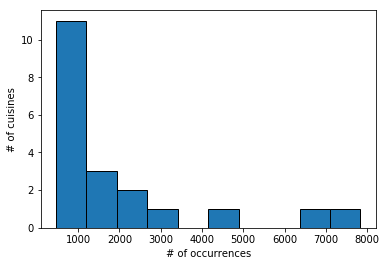

Summary statistics of above graph
            series
count    20.000000
mean   1988.700000
std    2041.558772
min     467.000000
25%     791.750000
50%    1082.000000
75%    2652.750000
max    7838.000000


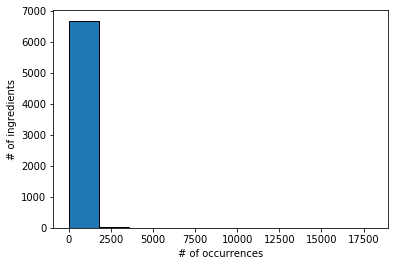

Summary statistics of above graph
             series
count   6714.000000
mean      63.788353
std      388.355948
min        1.000000
25%        1.000000
50%        4.000000
75%       20.000000
max    18049.000000
Average number of ingredients per recipe: 10.7677125761
Std. dev. number of ingredients per recipe: 4.42892189306


In [141]:
import json
import numpy as np

cuisines = set()
ingredients = set()

cuisine_count_map = {}
ingredient_count_map = {}

num_ingredients_per_recipe = []

def show_hist_of_dict(count_map, y_label, x_label):
    import matplotlib.pyplot as plt
    % matplotlib inline
    fig, ax = plt.subplots(1, 1)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.hist(count_map.values(), ec='black')
    plt.show()
    
    # print summary statistics
    print('Summary statistics of above graph')
    import pandas as pd
    series = {'series': pd.Series(count_map.values())}
    data_frame = pd.DataFrame(series)
    print(data_frame.describe())


with open('whats-cooking/train.json', 'r') as file:
    data = json.load(file)
    
    # print number of recipes
    print('Total number of recipes: {}'.format(len(data)))
    
    for recipe in data:
    
        # stats on number of cuisines
        cuisines.add(recipe['cuisine'])
        if recipe['cuisine'] not in cuisine_count_map:
            cuisine_count_map[recipe['cuisine']] = 0
        cuisine_count_map[recipe['cuisine']] += 1
        
        # stats on number of ingredients
        num_ingredients_per_recipe.append(len(recipe['ingredients']))
        for ingredient in recipe['ingredients']:
            ingredients.add(ingredient)
            
            if ingredient not in ingredient_count_map:
                ingredient_count_map[ingredient] = 0
            ingredient_count_map[ingredient] += 1
    
    print('Number of cuisines: {}'.format(len(cuisines)))
    print('Cuisine count map: \n')
    for cuisine in cuisine_count_map:
        print('{:>15}: {}'.format(cuisine, cuisine_count_map[cuisine]))
    print('\n')
    print('Number of ingredients: {}'.format(len(ingredients)))
    
    # show histogram of ingredients and cuisines
    show_hist_of_dict(cuisine_count_map, '# of cuisines', '# of occurrences')
    show_hist_of_dict(ingredient_count_map, '# of ingredients', '# of occurrences')
    
    # print average number of ingredients per recipe
    print('Average number of ingredients per recipe: {}'.format(np.mean(num_ingredients_per_recipe)))
    print('Std. dev. number of ingredients per recipe: {}'.format(np.std(num_ingredients_per_recipe)))

From the above, we can reason that most ingredients are used sparingly while only a few ingredients are used a lot

### 2.2 Explore test data

Total number of recipes: 9944
Number of ingredients: 4484


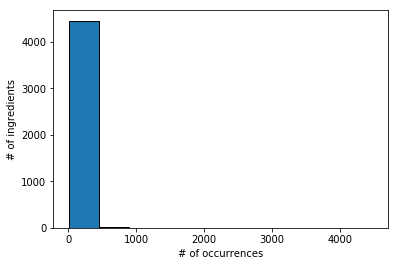

Summary statistics of above graph
            series
count  4484.000000
mean     23.950714
std     117.785328
min       1.000000
25%       1.000000
50%       3.000000
75%      11.000000
max    4485.000000
Statistics on number of ingredients per recipe:
Average number of ingredients per recipe: 10.7999798874
Std. dev. number of ingredients per recipe: 4.46692907371
            series
count  9944.000000
mean     10.799980
std       4.467154
min       1.000000
25%       8.000000
50%      10.000000
75%      13.000000
max      50.000000


In [67]:
import json
import numpy as np

ingredients = set()
ingredient_count_map = {}
num_ingredients_per_recipe = []

def show_hist_of_dict(count_map, y_label, x_label):
    import matplotlib.pyplot as plt
    % matplotlib inline
    fig, ax = plt.subplots(1, 1)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.hist(count_map.values(), ec='black')
    plt.show()
    
    # print summary statistics
    print('Summary statistics of above graph')
    import pandas as pd
    series = {'series': pd.Series(count_map.values())}
    data_frame = pd.DataFrame(series)
    print(data_frame.describe())


with open('whats-cooking/test.json', 'r') as file:
    data = json.load(file)
    
    # print number of recipes
    print('Total number of recipes: {}'.format(len(data)))
    
    for recipe in data:
            
        # stats on number of ingredients
        num_ingredients_per_recipe.append(len(recipe['ingredients']))
        for ingredient in recipe['ingredients']:
            ingredients.add(ingredient)
            
            if ingredient not in ingredient_count_map:
                ingredient_count_map[ingredient] = 0
            ingredient_count_map[ingredient] += 1
    
    print('Number of ingredients: {}'.format(len(ingredients)))
    
    # show histogram of ingredients and cuisines
    show_hist_of_dict(ingredient_count_map, '# of ingredients', '# of occurrences')
    
    # print average number of ingredients per recipe
    print('Statistics on number of ingredients per recipe:')
    print('Average number of ingredients per recipe: {}'.format(np.mean(num_ingredients_per_recipe)))
    print('Std. dev. number of ingredients per recipe: {}'.format(np.std(num_ingredients_per_recipe)))
    import pandas as pd
    series = {'series': pd.Series(num_ingredients_per_recipe)}
    data_frame = pd.DataFrame(series)
    print(data_frame.describe())

From the above, we can reason that even in test data most ingredients are used sparingly while only a few occur a lot of times

## 3. Create a separate train-test split from original train data

Although we could evaluate results of each model on Kaggle's hidden test set, we here create a separate train-test split using the training set from Kaggle so that we can do our own analysis properly. This is necessary since Kaggle's test set is hidden and we don't have access to it, so we can only get the accuracy result on that by submitting on Kaggle and no other metric can be evaluated as such; but if we create our own train-test split we can do a more in-depth analysis (through, say, a confusion matrix)

In [2]:
import random
import json

# ratio of original data to be held out
test_percent = 0.3

with open('whats-cooking/train.json', 'r') as file:
    data = json.load(file)
    random.shuffle(data)
    
    test_len = int(test_percent * len(data))
    test_split = data[:test_len]
    train_split = data[test_len:]
    
    with open('my_train_split.json', 'w') as outfile:
        json.dump(train_split, outfile, indent=4)
    with open('my_test_split.json', 'w') as outfile:
        json.dump(test_split, outfile, indent=4)

In [4]:
# cross-check
files = ['my_train_split.json', 'my_test_split.json', 'whats-cooking/train.json']

for filename in files:
    with open(filename, 'r') as infile:
        data = json.load(infile)
        print('{} has {} entries'.format(filename, len(data)))

my_train_split.json has 27842 entries
my_test_split.json has 11932 entries
whats-cooking/train.json has 39774 entries


## 4. Baseline heuristics

Define some helper functions

In [136]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# returns most common element in a list
def most_common(lst):
    return max(set(lst), key=lst.count)
# function to plot confusion matrix
def show_confusion_matrix(y_predicted, y_true, label_to_string_map=None):
    # labels, counts = np.unique(y_true, return_counts=True)
    labels = np.unique(list(cuisines))
    map_label_to_index = { label : i for i, label in enumerate(labels) }
    
    # compute confusion matrix
    confusion_matrix = np.zeros((labels.shape[0], labels.shape[0]), dtype=int)
    for prediction_label, true_label in zip(y_predicted, y_true):
        confusion_matrix[map_label_to_index[true_label], map_label_to_index[prediction_label]] += 1
    
    # plot confusion matrix
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    fig.suptitle('Confusion matrix', fontsize=20)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    labels_yaxes = [ '{}'.format(label) for label in labels ]
    labels_xaxes = [ '{}'.format(label) for label in labels ]
    ax.set_xticklabels([''] + labels_xaxes)
    ax.set_yticklabels([''] + labels_yaxes)
    im = ax.matshow(confusion_matrix, cmap='coolwarm')
    # attribution for following two lines: https://stackoverflow.com/questions/20998083/show-the-values-in-the-grid-using-matplotlib
    for (i, j), z in np.ndenumerate(confusion_matrix):
        ax.text(j, i, '{}'.format(z), ha='center', va='center')
    fig.colorbar(im)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.tick_params(axis='x', labelrotation=60)
    plt.show()

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# function that prints analysis metrics between ground truth and predictions
def common_validate(ground_truth_labels, predictions):
    
    # show confusion matrix
    show_confusion_matrix(predictions, ground_truth_labels)
    
    # show accuracy
    accuracy = accuracy_score(ground_truth_labels, predictions)
    print('1. Accuracy = {} (i.e. {} %)\n'.format(accuracy, accuracy * 100))
    
    # show f1-score
    labels = np.unique(ground_truth_labels)
    f1_scores = f1_score(ground_truth_labels, predictions, labels=labels,average=None)
    print('2. f1_scores for each class:\n')
    for i, label in enumerate(labels):
        print('{:>20}:\t{:.4f}'.format(label, f1_scores[i]))
    print('\n')
    print('3. avg f1_score (without considering class imbalance): {}\n'.format(f1_score(ground_truth_labels, predictions, average='macro')))
    print('4. avg f1_score (weighted by considering class imbalance): {}\n'.format(f1_score(ground_truth_labels, predictions, average='weighted')))

### 4.1 Baseline #1
For each ingredient belonging to the given test ingredient list, find the cuisine in which this ingredient is used the most. Among all such cuisines, pick the most frequently occurring cuisine

In [137]:
import json
import operator

class Baseline_1_Model:
    
    def __init__(self):
        is_trained = False
    
    # trains the model with entries from train_file
    def train(self, train_file):
        self.ingredient_cuisine_count_map = {}
        self.ingredients = set()
    
        # calculate for each ingredient, how many times it appears in each cuisine
        with open(train_file, 'r') as file:
            data = json.load(file)    
            for recipe in data:
                for ingredient in recipe['ingredients']:  
                    self.ingredients.add(ingredient)
                    if ingredient not in self.ingredient_cuisine_count_map:
                        self.ingredient_cuisine_count_map[ingredient] = {}
                    if recipe['cuisine'] not in self.ingredient_cuisine_count_map[ingredient]:
                        self.ingredient_cuisine_count_map[ingredient][recipe['cuisine']] = 0
                    self.ingredient_cuisine_count_map[ingredient][recipe['cuisine']] += 1
        
        self.is_trained = True
    
    # returns prediction results for entries of infile
    # it returns two arrays ids, predictions
    # predictions[i] is the predicted cuisine of entry with id ids[i]
    def predict(self, infile):
        assert self.is_trained, 'model not trained yet!'
        
        # a function that returns cuisine in which a given ingredient is used most
        def most_used_cuisine_of_ingredient(ingredient):
            return max(self.ingredient_cuisine_count_map[ingredient].iteritems(), key=operator.itemgetter(1))[0]

        predictions = []
        ids = []
        with open(infile, 'r') as file:
            data = json.load(file)
            for recipe in data:
                candidate_cuisines = []
                for ingredient in recipe['ingredients']:
                    if ingredient in self.ingredients:
                        candidate_cuisines.append(most_used_cuisine_of_ingredient(ingredient))
                predicted_cuisine = most_common(candidate_cuisines)
                predictions.append(predicted_cuisine)
                ids.append(recipe['id'])
                
        return ids, predictions
    
    # validates already trained model against entries from validation_file
    def validate(self, validation_file):
        assert self.is_trained, 'model not trained yet!'
        ids, predictions = self.predict(validation_file)
        id_to_ground_truth_cuisine = {}
        with open(validation_file, 'r') as infile:
            data = json.load(infile)
            for recipe in data:
                id_to_ground_truth_cuisine[recipe['id']] = recipe['cuisine']
        ground_truth_labels = [id_to_ground_truth_cuisine[id] for id in ids]
        common_validate(ground_truth_labels, predictions)
    
    # writes out prediction of already trained model on entries of test_file to out_file
    # out_file can then be submitted on Kaggle
    def write_prediction(self, test_file, outfile):
        assert self.is_trained, 'model not trained yet!'
        with open(outfile, 'w') as out_file:
            out_file.write('id,cuisine\n')
            ids, predictions = self.predict(test_file)
            assert len(ids) == len(predictions), 'these should be equal'
            N = len(ids)
            for i in range(N):
                out_file.write('{},{}\n'.format(ids[i], predictions[i]))

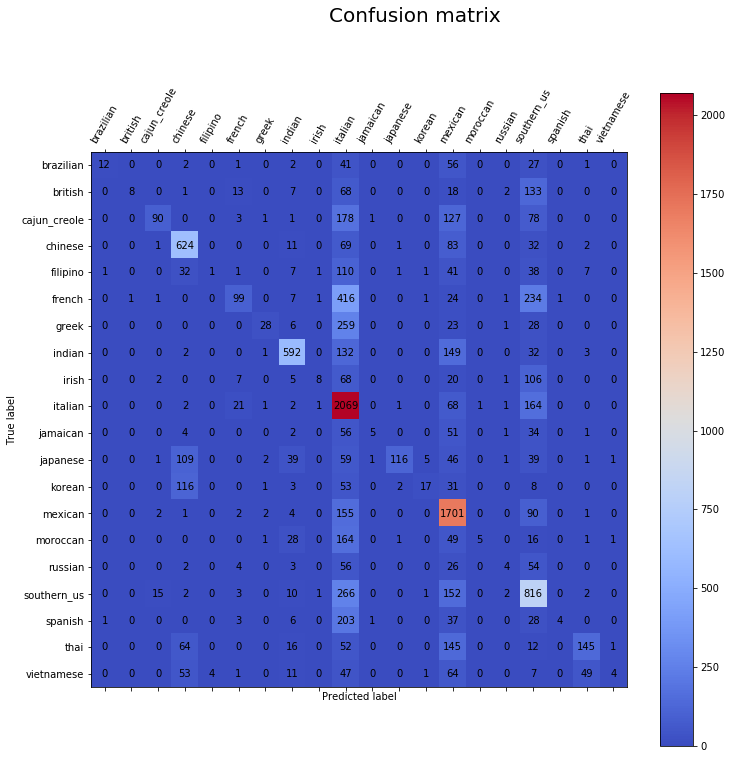

1. Accuracy = 0.532014750251 (i.e. 53.2014750251 %)

2. f1_scores for each class:

           brazilian:	0.1538
             british:	0.0618
        cajun_creole:	0.3046
             chinese:	0.6794
            filipino:	0.0081
              french:	0.2097
               greek:	0.1466
              indian:	0.7077
               irish:	0.0699
             italian:	0.6039
            jamaican:	0.0617
            japanese:	0.4280
              korean:	0.1323
             mexican:	0.6987
            moroccan:	0.0368
             russian:	0.0491
         southern_us:	0.5028
             spanish:	0.0278
                thai:	0.4475
          vietnamese:	0.0323


3. avg f1_score (without considering class imbalance): 0.26812406245

4. avg f1_score (weighted by considering class imbalance): 0.459364215925



In [138]:
# analyze on our own train-test split
baseline_1_model = Baseline_1_Model()
baseline_1_model.train('my_train_split.json')
baseline_1_model.validate('my_test_split.json')

** Inferences from above results **

1. From the confusion matrix, we can see that this model predicts some cuisines a lot of times (such as italian, mexican). This is not surprising given the logic with which the model is making the predictions; the cuisines that the model is predicting often are also the ones that occur in data a lot many times and the ones that the model is predicting sparingly are the ones that occur the very less number of times in the data
2. Accuracy that we achieve here is about 53%
3. From the f1-scores of each class, it is immediately apparent that those cuisines that we predict frequently (such as italian, mexican, southern_us, etc.) have higher f1-scores than those cuisines that we predict sparingly (such as brazilian, irish, moroccan, etc.). This is not surprising given the logic with which the model is making the predictions
4. Due to this imbalance of f1-scores based on the frequency of cuisine's occurrence, the unweighted average f1-score turns out to be significanly smaller (around 0.26) than its weighted counterpart (around 0.45)

Now we train the baseline model on entire training data that is available and then make predictions on Kaggle's test data (whose ground truth we don't know) and submit on Kaggle to check the accuracy we get

In [62]:
# train on entire data set and check accuracy on Kaggle
baseline_1_model_whole = Baseline_1_Model()
baseline_1_model_whole.train('whats-cooking/train.json')
baseline_1_model_whole.write_prediction('whats-cooking/test.json', 'Submissions/baseline_1_submission.csv')

I submitted the results of above baseline on Kaggle and got an accuracy of 0.53047 (i.e. **53.047 %**). The accuracy is similar to the one we got on our own train-test split.

### 4.2 Baseline #2
Rank the set of training recipes based on number of ingredients common with test ingredient list. Assign weights to recipes based on their rank and add to scores of their corresponding cuisines. Finally, choose the cuisine with the highest score

In [146]:
import json
import operator

class Baseline_2_Model:
    
    def __init__(self):
        is_trained = False
    
    # trains the model with entries from train_file
    def train(self, train_file):
        self.recipes = []
        with open(train_file, 'r') as file:
            data = json.load(file)    
            for recipe in data:
                self.recipes.append(recipe)
        self.is_trained = True
    
    # returns prediction results for entries of infile
    # it returns two arrays ids, predictions
    # predictions[i] is the predicted cuisine of entry with id ids[i]
    def predict(self, infile):
        assert self.is_trained, 'model not trained yet!'
        
        predictions = []
        ids = []
        with open(infile, 'r') as file:
            data = json.load(file)
            M = len(data)
            for recipe_num, recipe in enumerate(data):
                # print progress
                if recipe_num % int((M * 0.10)) == 0:
                    print('{}% of predictions done'.format(recipe_num * 100.0 / M))
                
                common_ingredient_counts = []
                for train_recipe in self.recipes:
                    common_ingredients = set(recipe['ingredients']) - (set(recipe['ingredients']) - set(train_recipe['ingredients']))
                    common_ingredient_counts.append(len(common_ingredients))

                
                # calculate score for each cuisine
                total_count = sum(common_ingredient_counts)
                W = 100000.0
                score_cuisines = {}
                for i, train_recipe in enumerate(self.recipes):
                    if train_recipe['cuisine'] not in score_cuisines:
                            score_cuisines[train_recipe['cuisine']] = 0.0
                    score_cuisines[train_recipe['cuisine']] += (float(common_ingredient_counts[i]) / total_count)
                    
                # pick the cuisine with highest score
                predicted_cuisine = max(score_cuisines.iteritems(), key=operator.itemgetter(1))[0]
                predictions.append(predicted_cuisine)
                ids.append(recipe['id'])
                
        return ids, predictions
    
    # validates already trained model against entries from validation_file
    def validate(self, validation_file):
        assert self.is_trained, 'model not trained yet!'
        ids, predictions = self.predict(validation_file)
        id_to_ground_truth_cuisine = {}
        with open(validation_file, 'r') as infile:
            data = json.load(infile)
            for recipe in data:
                id_to_ground_truth_cuisine[recipe['id']] = recipe['cuisine']
        ground_truth_labels = [id_to_ground_truth_cuisine[id] for id in ids]
        common_validate(ground_truth_labels, predictions)
    
    # writes out prediction of already trained model on entries of test_file to out_file
    # out_file can then be submitted on Kaggle
    def write_prediction(self, test_file, outfile):
        assert self.is_trained, 'model not trained yet!'
        with open(outfile, 'w') as out_file:
            out_file.write('id,cuisine\n')
            ids, predictions = self.predict(test_file)
            assert len(ids) == len(predictions), 'these should be equal'
            N = len(ids)
            for i in range(N):
                out_file.write('{},{}\n'.format(ids[i], predictions[i]))

0.0% of predictions done
9.99832383507% of predictions done
19.9966476701% of predictions done
29.9949715052% of predictions done
39.9932953403% of predictions done
49.9916191753% of predictions done
59.9899430104% of predictions done
69.9882668455% of predictions done
79.9865906805% of predictions done
89.9849145156% of predictions done
99.9832383507% of predictions done


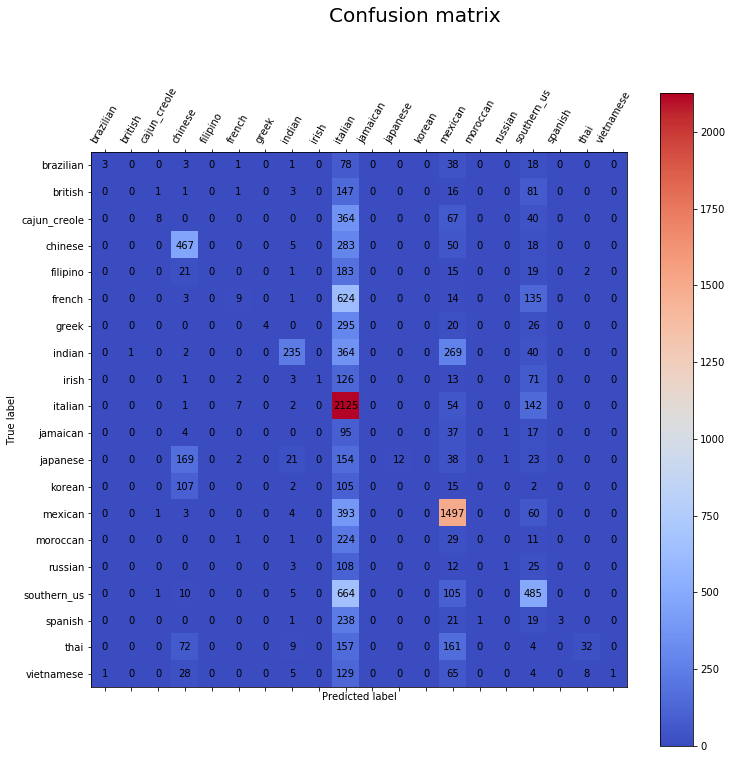

1. Accuracy = 0.40923566879 (i.e. 40.923566879 %)

2. f1_scores for each class:

           brazilian:	0.0411
             british:	0.0000
        cajun_creole:	0.0327
             chinese:	0.5446
            filipino:	0.0000
              french:	0.0222
               greek:	0.0229
              indian:	0.3875
               irish:	0.0092
             italian:	0.4626
            jamaican:	0.0000
            japanese:	0.0556
              korean:	0.0000
             mexican:	0.6662
            moroccan:	0.0000
             russian:	0.0132
         southern_us:	0.3865
             spanish:	0.0210
                thai:	0.1342
          vietnamese:	0.0083


3. avg f1_score (without considering class imbalance): 0.140379297679

4. avg f1_score (weighted by considering class imbalance): 0.319749399916



In [147]:
# analyze on our own train-test split
baseline_2_model = Baseline_2_Model()
baseline_2_model.train('my_train_split.json')
baseline_2_model.validate('my_test_split.json')

Note: Above code took around 30 minutes to calculate predictions

** Inferences from above results **

1. From the confusion matrix, we can see that this model predicts some cuisines a lot of times (such as italian, mexican). This is probably because of the fact that since these cuisines occur a lot frequently, their score tends to become significant because of many (though small) score contributions. We can try a different heuristic by adding a larger power of common ingredients to handle this issue (see Baseline 2b)
2. Accuracy that we achieve here is about 40%
3. From the f1-scores of each class, it is immediately apparent that those cuisines that we predict frequently (such as italian, mexican, southern_us, etc.) have higher f1-scores than those cuisines that we predict sparingly (such as brazilian, irish, moroccan, etc.). This is not surprising given the logic with which the model is making the predictions
4. Due to this imbalance of f1-scores based on the frequency of cuisine's occurrence, the unweighted average f1-score turns out to be significanly smaller (around 0.14) than its weighted counterpart (around 0.31)

Now we train the baseline model on entire training data that is available and then make predictions on Kaggle's test data (whose ground truth we don't know) and submit on Kaggle to check the accuracy we get

In [148]:
# train on entire data set and check accuracy on Kaggle
baseline_2_model_whole = Baseline_2_Model()
baseline_2_model_whole.train('whats-cooking/train.json')
baseline_2_model_whole.write_prediction('whats-cooking/test.json', 'Submissions/baseline_2_submission.csv')

0.0% of predictions done
9.99597747385% of predictions done
19.9919549477% of predictions done
29.9879324216% of predictions done
39.9839098954% of predictions done
49.9798873693% of predictions done
59.9758648431% of predictions done
69.971842317% of predictions done
79.9678197908% of predictions done
89.9637972647% of predictions done
99.9597747385% of predictions done


I submitted the results of above baseline on Kaggle and got an accuracy of 0.40335 (i.e. **40.335 %**). The accuracy is similar to the one we got on our own train-test split.

### 4.3 Baseline #2(b)
This is same as Baseline #2 except here we add a higher power of number of common ingredients (in particular, power 3 i.e. cube) instead of power 1. This is in hope that this may help tackle the issue faced by previous model

In [158]:
import json
import operator

class Baseline_2b_Model:
    
    def __init__(self):
        is_trained = False
    
    # trains the model with entries from train_file
    def train(self, train_file):
        self.recipes = []
        with open(train_file, 'r') as file:
            data = json.load(file)    
            for recipe in data:
                self.recipes.append(recipe)
        self.is_trained = True
    
    # returns prediction results for entries of infile
    # it returns two arrays ids, predictions
    # predictions[i] is the predicted cuisine of entry with id ids[i]
    def predict(self, infile):
        assert self.is_trained, 'model not trained yet!'
        
        predictions = []
        ids = []
        with open(infile, 'r') as file:
            data = json.load(file)
            M = len(data)
            for recipe_num, recipe in enumerate(data):
                # print progress
                if recipe_num % int((M * 0.10)) == 0:
                    print('{}% of predictions done'.format(recipe_num * 100.0 / M))
                
                common_ingredient_counts = []
                for train_recipe in self.recipes:
                    common_ingredients = set(recipe['ingredients']) - (set(recipe['ingredients']) - set(train_recipe['ingredients']))
                    common_ingredient_counts.append(len(common_ingredients))

                
                # calculate score for each cuisine
                total_count = sum(common_ingredient_counts)
                W = 100000.0
                score_cuisines = {}
                for i, train_recipe in enumerate(self.recipes):
                    if train_recipe['cuisine'] not in score_cuisines:
                            score_cuisines[train_recipe['cuisine']] = 0.0
                    score_cuisines[train_recipe['cuisine']] += (float(pow(common_ingredient_counts[i], 3)) / total_count)
                    
                # pick the cuisine with highest score
                predicted_cuisine = max(score_cuisines.iteritems(), key=operator.itemgetter(1))[0]
                predictions.append(predicted_cuisine)
                ids.append(recipe['id'])
                
        return ids, predictions
    
    # validates already trained model against entries from validation_file
    def validate(self, validation_file):
        assert self.is_trained, 'model not trained yet!'
        ids, predictions = self.predict(validation_file)
        id_to_ground_truth_cuisine = {}
        with open(validation_file, 'r') as infile:
            data = json.load(infile)
            for recipe in data:
                id_to_ground_truth_cuisine[recipe['id']] = recipe['cuisine']
        ground_truth_labels = [id_to_ground_truth_cuisine[id] for id in ids]
        common_validate(ground_truth_labels, predictions)
    
    # writes out prediction of already trained model on entries of test_file to out_file
    # out_file can then be submitted on Kaggle
    def write_prediction(self, test_file, outfile):
        assert self.is_trained, 'model not trained yet!'
        with open(outfile, 'w') as out_file:
            out_file.write('id,cuisine\n')
            ids, predictions = self.predict(test_file)
            assert len(ids) == len(predictions), 'these should be equal'
            N = len(ids)
            for i in range(N):
                out_file.write('{},{}\n'.format(ids[i], predictions[i]))

0.0% of predictions done
9.99832383507% of predictions done
19.9966476701% of predictions done
29.9949715052% of predictions done
39.9932953403% of predictions done
49.9916191753% of predictions done
59.9899430104% of predictions done
69.9882668455% of predictions done
79.9865906805% of predictions done
89.9849145156% of predictions done
99.9832383507% of predictions done


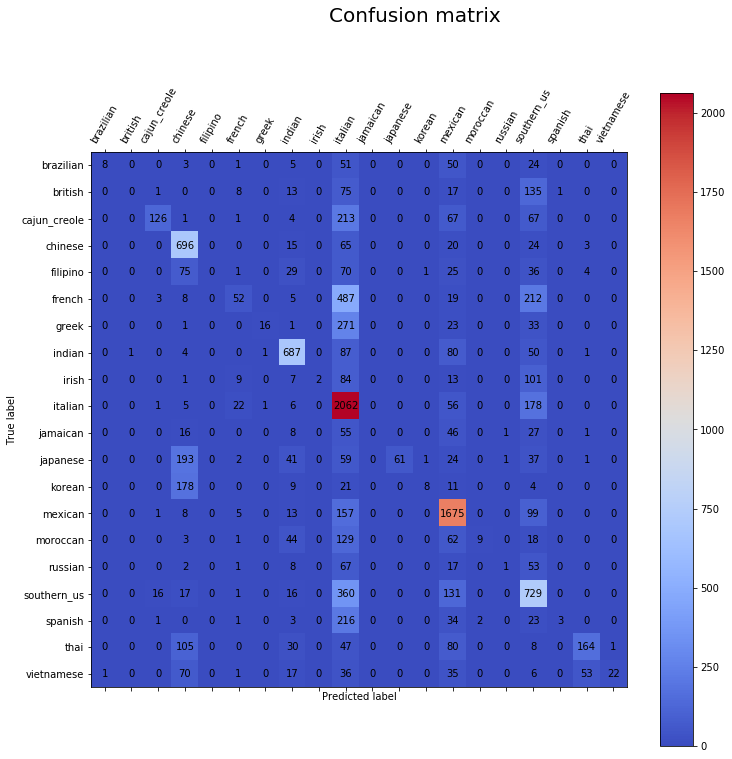

1. Accuracy = 0.52975192759 (i.e. 52.975192759 %)

2. f1_scores for each class:

           brazilian:	0.1060
             british:	0.0000
        cajun_creole:	0.4013
             chinese:	0.6301
            filipino:	0.0000
              french:	0.1166
               greek:	0.0882
              indian:	0.7340
               irish:	0.0183
             italian:	0.5940
            jamaican:	0.0000
            japanese:	0.2536
              korean:	0.0664
             mexican:	0.7540
            moroccan:	0.0650
             russian:	0.0132
         southern_us:	0.4652
             spanish:	0.0209
                thai:	0.4955
          vietnamese:	0.1667


3. avg f1_score (without considering class imbalance): 0.249438635292

4. avg f1_score (weighted by considering class imbalance): 0.450467479212



In [159]:
# analyze on our own train-test split
baseline_2b_model = Baseline_2b_Model()
baseline_2b_model.train('my_train_split.json')
baseline_2b_model.validate('my_test_split.json')

Note: Above code took around 30 minutes to calculate predictions

** Inferences from above results are identical to those of Baseline #1 **

Now we train this baseline model on entire training data that is available and then make predictions on Kaggle's test data (whose ground truth we don't know) and submit on Kaggle to check the accuracy we get

In [160]:
# train on entire data set and check accuracy on Kaggle
baseline_2b_model_whole = Baseline_2b_Model()
baseline_2b_model_whole.train('whats-cooking/train.json')
baseline_2b_model_whole.write_prediction('whats-cooking/test.json', 'Submissions/baseline_2b_submission.csv')

0.0% of predictions done
9.99597747385% of predictions done
19.9919549477% of predictions done
29.9879324216% of predictions done
39.9839098954% of predictions done
49.9798873693% of predictions done
59.9758648431% of predictions done
69.971842317% of predictions done
79.9678197908% of predictions done
89.9637972647% of predictions done
99.9597747385% of predictions done


I submitted the results of above baseline on Kaggle and got an accuracy of 0.52916 (i.e. **52.916 %**). The accuracy is similar to the one we got on our own train-test split.

## 5. Machine Learning

### 5.1 Create one-hot encoded train/test X, y matrices

In [192]:
# assign ids to cuisines
cuisine_to_id = {}
id_to_cuisine = {}

counter = 0
for cuisine in cuisines:
    cuisine_to_id[cuisine] = counter
    id_to_cuisine[counter] = cuisine
    counter += 1
    
# assign ids to ingredients
ingredient_to_id = {}
id_to_ingredient = {}

counter = 0
for ingredient in ingredients:
    ingredient_to_id[ingredient] = counter
    id_to_ingredient[counter] = ingredient
    counter += 1

# function that returns X, Y matrices by reading infile
def create_supervised_one_hot(infile, create_y=True):
    with open(infile, 'r') as file:
        data = json.load(file)
        num_samples = len(data)
        num_ingredients = len(ingredients)
        num_cuisines = len(cuisines)
        print('num_samples = {}'.format(num_samples))
        print('num_ingredients = {}'.format(num_ingredients))
        print('num_cuisines = {}'.format(num_cuisines))
        X = np.zeros(shape=(num_samples, num_ingredients))
        if create_y:
            Y = np.zeros(shape=(num_samples, num_cuisines))
        for i, recipe in enumerate(data):
            for ingredient_in_this in recipe['ingredients']:
                if ingredient_in_this in ingredient_to_id:
                    X[i, ingredient_to_id[ingredient_in_this]] = 1.0
            if create_y:
                Y[i, cuisine_to_id[recipe['cuisine']]] = 1.0
        if create_y:
            return X, Y
        else:
            return X

# create X, Y matrices
X, Y = create_supervised_one_hot('whats-cooking/train.json')
print('X.shape = {}'.format(X.shape))
print('Y.shape = {}'.format(Y.shape))

# create train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=True)
print('X_train.shape = {}'.format(X_train.shape))
print('Y_train.shape = {}'.format(Y_train.shape))
print('X_test.shape = {}'.format(X_test.shape))
print('Y_test.shape = {}'.format(Y_test.shape))

num_samples = 39774
num_ingredients = 6714
num_cuisines = 20
X.shape = (39774, 6714)
Y.shape = (39774, 20)
X_train.shape = (27841, 6714)
Y_train.shape = (27841, 20)
X_test.shape = (11933, 6714)
Y_test.shape = (11933, 20)


### 5.2 Train neural network (on 1-hot encoded matrices)

We use Keras deep learning library to create a fully connected neural network with dropout for regularization between layers.

In [196]:
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

import matplotlib.pyplot as plt

class NN:
    def __init__(self):
        is_trained = False
    
    # trains the model
    def train(self, X_train, Y_train, X_validation, Y_validation):
        
        # create NN architecture
        self.model = Sequential()
        self.model.add(Dense(2000, activation='relu', input_dim=X_train.shape[1]))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(200, activation='relu'))
        self.model.add(Dropout(0.1))
        self.model.add(Dense(Y_train.shape[1], activation='softmax'))
    
        # compile the model
        sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        self.model.compile(loss='categorical_crossentropy',
                      optimizer=sgd,
                      metrics=['accuracy'])
    
        # train the model
        history = self.model.fit(X_train, Y_train, epochs=25, batch_size=128, verbose=1, validation_data=(X_validation, Y_validation))
        self.is_trained = True
                
        # plot train/validation accuracy as a function of epochs
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        fig.suptitle('Accuracy as a function of training epochs')
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Epochs')
        ax.plot(range(len(history.history['acc'])), history.history['acc'], color='blue')
        ax.plot(range(len(history.history['acc'])), history.history['acc'], marker='o', color='blue', label='Training accuracy')
        ax.plot(range(len(history.history['val_acc'])), history.history['val_acc'], color='#f39c12')
        ax.plot(range(len(history.history['val_acc'])), history.history['val_acc'], marker='o', color='#f39c12', label='Validation accuracy')

        ax.legend()
        plt.show()
        plt.close(fig)
    
    # returns prediction results for samples of X_test
    def predict(self, X_test):
        assert self.is_trained, 'model not trained yet!'
        
        # predict
        Y_predicted = self.model.predict(X_test)
        
        # convert one-hot predictions to cuisine labels
        predictions = []
        for i in range(Y_predicted.shape[0]):
            predictions.append(id_to_cuisine[np.argmax(Y_predicted[i, :])])
                
        return predictions
    
    # validates already trained model against X_test, Y_test
    def validate(self, X_test, Y_test):
        assert self.is_trained, 'model not trained yet!'
        predictions = self.predict(X_test)
        ground_truth_labels = [ id_to_cuisine[np.argmax(Y_test[i, :])] for i in range(Y_test.shape[0])]
        common_validate(ground_truth_labels, predictions)
    
    # writes out prediction of already trained model on samples of X_test
    def write_prediction(self, infile, outfile):
        assert self.is_trained, 'model not trained yet!'
        
        X = create_supervised_one_hot(infile, create_y=False)
        ids = []
        with open(infile, 'r') as file:
            data = json.load(file)
            for recipe in data:
                ids.append(recipe['id'])
        
        with open(outfile, 'w') as out_file:
            out_file.write('id,cuisine\n')
            predictions = self.predict(X)
            assert len(ids) == len(predictions), 'these should be equal'
            N = len(ids)
            for i in range(N):
                out_file.write('{},{}\n'.format(ids[i], predictions[i]))

Train on 27841 samples, validate on 11933 samples
Epoch 1/25
27841/27841 [==============================] - 76s 3ms/step - loss: 2.2979 - acc: 0.3628 - val_loss: 1.7495 - val_acc: 0.5084
Epoch 2/25
27841/27841 [==============================] - 78s 3ms/step - loss: 1.4772 - acc: 0.5777 - val_loss: 1.2977 - val_acc: 0.6217
Epoch 3/25
27841/27841 [==============================] - 77s 3ms/step - loss: 1.1672 - acc: 0.6598 - val_loss: 1.1036 - val_acc: 0.6790
Epoch 4/25
27841/27841 [==============================] - 70s 3ms/step - loss: 1.0099 - acc: 0.7066 - val_loss: 1.0073 - val_acc: 0.7025
Epoch 5/25
27841/27841 [==============================] - 77s 3ms/step - loss: 0.9076 - acc: 0.7326 - val_loss: 0.9381 - val_acc: 0.7250
Epoch 6/25
27841/27841 [==============================] - 77s 3ms/step - loss: 0.8303 - acc: 0.7537 - val_loss: 0.9016 - val_acc: 0.7320
Epoch 7/25
27841/27841 [==============================] - 72s 3ms/step - loss: 0.7687 - acc: 0.7731 - val_loss: 0.8609 - val_acc

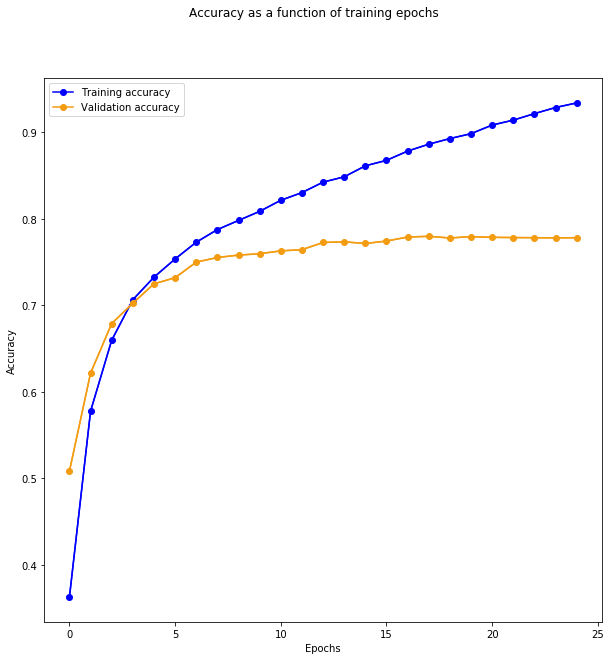

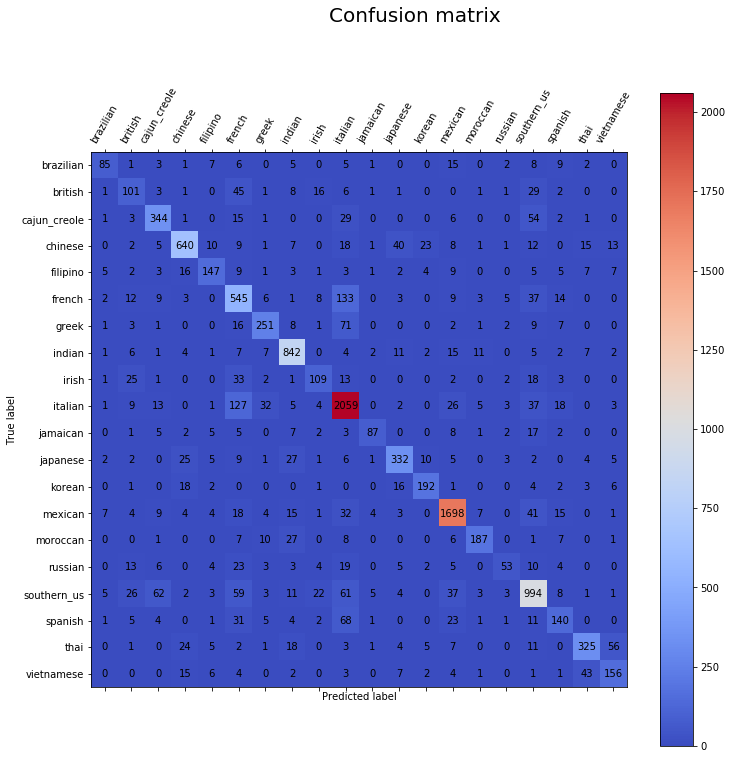

1. Accuracy = 0.778261962625 (i.e. 77.8261962625 %)

2. f1_scores for each class:

           brazilian:	0.6464
             british:	0.4654
        cajun_creole:	0.7422
             chinese:	0.8195
            filipino:	0.6821
              french:	0.6193
               greek:	0.7151
              indian:	0.8753
               irish:	0.5707
             italian:	0.8423
            jamaican:	0.6905
            japanese:	0.7632
              korean:	0.7901
             mexican:	0.9049
            moroccan:	0.7841
             russian:	0.4569
         southern_us:	0.7599
             spanish:	0.5195
                thai:	0.7463
          vietnamese:	0.6290


3. avg f1_score (without considering class imbalance): 0.701131848892

4. avg f1_score (weighted by considering class imbalance): 0.776073126279

num_samples = 9944
num_ingredients = 6714
num_cuisines = 20


In [197]:
nn = NN()
nn.train(X_train, Y_train, X_test, Y_test)
nn.validate(X_test, Y_test)
nn.write_prediction('whats-cooking/test.json', 'Submissions/nn_one_hot_submission.csv')

Note: in the above code 1 epoch takes around 1 minute

On Kaggle, we get an accuracy of 0.78228 (i.e. **78.228%**)

### 5.3 Train SVM (on 1-hot encoded matrices)

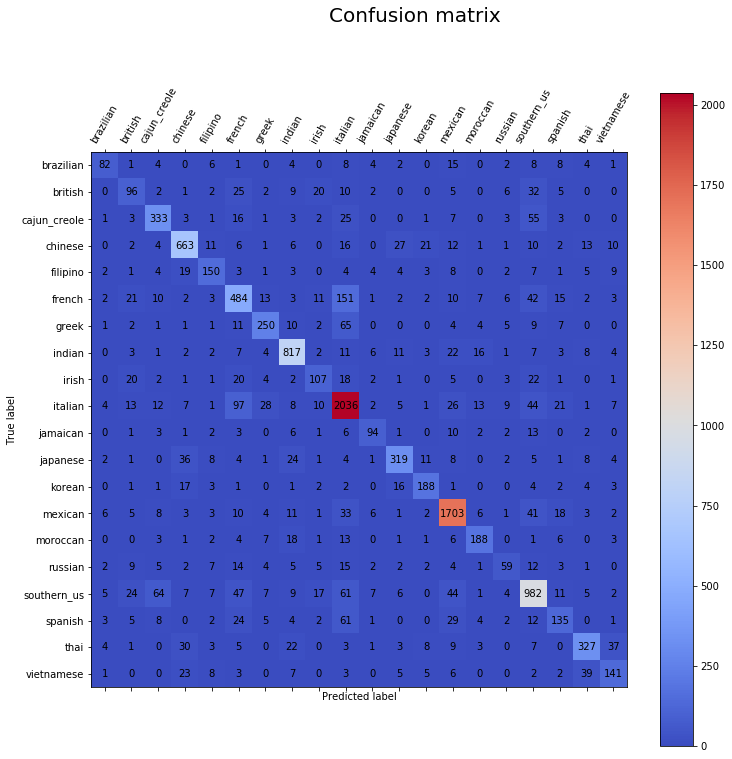

1. Accuracy = 0.767116399899 (i.e. 76.7116399899 %)

2. f1_scores for each class:

           brazilian:	0.6189
             british:	0.4507
        cajun_creole:	0.7223
             chinese:	0.8160
            filipino:	0.6623
              french:	0.6146
               greek:	0.7092
              indian:	0.8591
               irish:	0.5431
             italian:	0.8327
            jamaican:	0.6714
            japanese:	0.7541
              korean:	0.7611
             mexican:	0.8961
            moroccan:	0.7505
             russian:	0.4504
         southern_us:	0.7482
             spanish:	0.4982
                thai:	0.7390
          vietnamese:	0.5962


3. avg f1_score (without considering class imbalance): 0.684706763367

4. avg f1_score (weighted by considering class imbalance): 0.763835917825



In [202]:
from sklearn.svm import LinearSVC

# returns inverese of one-hot encoding
def inverse_one_hot(Y):
    y = np.zeros(shape=(Y.shape[0], ))
    for i in range(Y.shape[0]):
        y[i] = np.argmax(Y[i, :])
    return y

# train a linear SVM
svm = LinearSVC()
y_train = inverse_one_hot(Y_train)
svm.fit(X_train, y_train)

# evaluate results
y_predicted = svm.predict(X_test)
predictions = [ id_to_cuisine[y_predicted[i]] for i in range(y_predicted.shape[0])]
ground_truth_labels = [ id_to_cuisine[np.argmax(Y_test[i, :])] for i in range(Y_test.shape[0])]
common_validate(ground_truth_labels, predictions)

## 6. Machine Learning + Network domain

### 6.1 Node2Vec embeddings

Node2Vec embeddings of the unipartite projection network (where each node is an ingredient) of the recipe-ingredient bipartitite network are to be obtained. We use open-source node2vec codebase [available on Github](https://github.com/aditya-grover/node2vec) by its authors. This requires the graph in the format of an edge list. So, first we create the corresponding ingredient monopartite projection of the bipartite recipe-ingredient network

In [229]:
import json

def write_ingredient_ingredient_network_to_file(in_file, out_file):
        graph_id_to_ingredient = {}
        
        # create a map of what all recipes was each ingredient present in
        ingredient_to_recipes = {}
        with open(in_file, 'r') as file:
            data = json.load(file)
            for recipe in data:
                for ingredient in recipe['ingredients']:
                    if ingredient not in ingredient_to_recipes:
                        ingredient_to_recipes[ingredient] = set()
                    ingredient_to_recipes[ingredient].add(recipe['id'])
        
        # write out edges in edge-list format "node_1_id_int node_2_id_int weight_float"
        ingredients = list(ingredient_to_recipes.keys())
        for i, ingredient in enumerate(ingredients):
            graph_id_to_ingredient[i + 1] = ingredient
        N = len(ingredients)
        with open(out_file, 'w') as file:
            for i in range(N):
                for j in range(i + 1, N):
                    recipe_A = ingredient_to_recipes[ingredients[i]]
                    recipe_B = ingredient_to_recipes[ingredients[j]]
                    w = len(recipe_A.intersection(recipe_B))
                    if w > 0:
                        file.write('{} {} {}\n'.format(i + 1, j + 1, w))
        
        # return map
        return graph_id_to_ingredient

Now we write the monopartite projection graph out into a file in the edge list format so that we can then pass this to node2vec

In [230]:
graph_id_to_ingredient = write_ingredient_ingredient_network_to_file('my_train_split.json', 'embeddings/my_train_split_graph.edgelist')

Read graph from this file and see some network characteristics

In [231]:
import networkx as nx
G = nx.read_weighted_edgelist(open('embeddings/my_train_split_graph.edgelist', 'r')).to_undirected()

Number of nodes = 6070
Number of edges = 388057
Average number of neighbours = 127.86062603 +- 266.984577139
Max number of neighbours: 4366
Min number of neighbours: 1


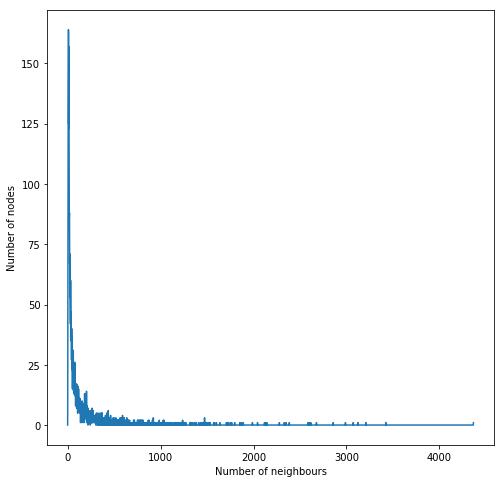

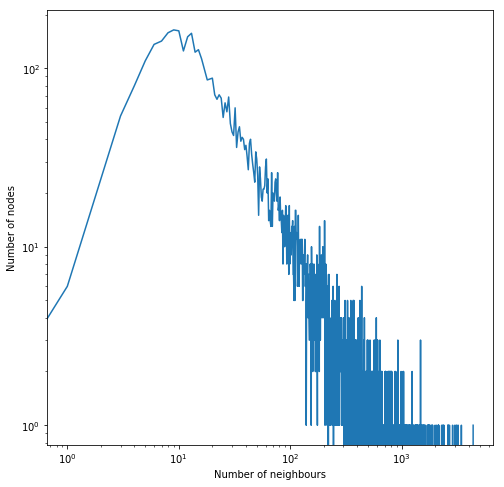

In [232]:
print('Number of nodes = {}'.format(G.number_of_nodes()))
print('Number of edges = {}'.format(G.number_of_edges()))
degrees = [ b for (_, b) in G.degree(G.nodes()) ]
print('Average number of neighbours = {} +- {}'.format(np.mean(degrees), np.std(degrees)))
print('Max number of neighbours: {}'.format(np.max(degrees)))
print('Min number of neighbours: {}'.format(np.min(degrees)))
degree_histogram = nx.degree_histogram(G)

# plot degree (unweighted) distribution
import matplotlib.pyplot as plt
% matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_xlabel('Number of neighbours')
ax.set_ylabel('Number of nodes')
ax.plot(list(range(len(degree_histogram))), degree_histogram)
plt.show()

# plot on log-log scale
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_xlabel('Number of neighbours')
ax.set_ylabel('Number of nodes')
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(list(range(len(degree_histogram))), degree_histogram)
plt.show()

#### NOTE: at this point, I run node2vec on the above graph through my console since that is more convenient than trying to run it from inside this Jupyter notebook. Nevertheless, I will show few embeddings inside this Jupyter notebook after saving it to a file.

I run Node2Vec on the above graph with the following parameter values:
1. Embedding dimension: 128
2. Walk length per source: 80
3. Number of walks per source: 10
4. Context window size for optimization: 10
5. Return hyperparameter P: 1
6. Inout hyperparameter Q: 1

Calculating node2vec embeddings on our large graph took around 1 hour
Now, we read embeddings back in memory from file

In [240]:
# map graph_id_to_ingredient contains id to ingredient name mappings

# read embeddings into memory
ingredient_to_embedding = {}
with open('embeddings/my_train_split_1_1.emb', 'r') as in_file:
    content = in_file.readlines()
    content = [x.strip() for x in content]
    N = len(content)
    for i in range(1, N):
        tokens = content[i].split(' ')
        id_ = int(tokens[0])
        embedding_ = np.array([ float(val) for val in tokens[1:] ])
        ingredient_to_embedding[graph_id_to_ingredient[id_]] = np.copy(embedding_)

For some selected ingredients, see which other ingredients turn out to have a high dot product with this ingredient's embedding i.e. which other ingredients are most common to given ingredient

In [262]:
def show_similar_n_ingredients(ingredient, N):
    lst = []
    for ingredient_ in ingredient_to_embedding.keys():
        lst.append((np.dot(ingredient_to_embedding[ingredient_], ingredient_to_embedding[ingredient]), ingredient_))
    lst = sorted(lst, reverse=True)
    
    print('Most similar ingredients to {} are: \n'.format(ingredient))
    for i in range(N):
        print('\t{} with dot product = {}'.format(lst[i][1], lst[i][0]))
    print('\n')

In [263]:
show_similar_n_ingredients('pasta', 10)

Most similar ingredients to pasta are: 

	pasta with dot product = 2.65396044812
	pasta sauce with dot product = 2.6088116153
	pizza sauce with dot product = 2.56046031793
	lasagna noodles with dot product = 2.53321010615
	italian sausage with dot product = 2.53107811963
	Alfredo sauce with dot product = 2.52069145991
	ricotta cheese with dot product = 2.51932971607
	jumbo pasta shells with dot product = 2.50478843364
	pepperoni with dot product = 2.47283784044
	mozzarella cheese with dot product = 2.45070912561




**We observe above that ingredients similar to pasta are those that are frequently used in italian cuisine. This suggests that embeddings we have learnt have some meaningful semantics as a node representation**

In [264]:
show_similar_n_ingredients('garam masala', 10)

Most similar ingredients to garam masala are: 

	garam masala with dot product = 3.26932325839
	shahi jeera with dot product = 3.20771460401
	mustard oil with dot product = 3.15104231526
	rajma with dot product = 3.14771942275
	kasuri methi with dot product = 3.11447291084
	asafoetida with dot product = 3.09232605438
	Biryani Masala with dot product = 3.07330004546
	methi with dot product = 3.04530542826
	toor dal with dot product = 3.03430954604
	gram flour with dot product = 3.03111158661




**We observe above that ingredients similar to garam masala contain those that are common in indian cuisine (garam masala is frequently used in indian cuisine). This suggests that embeddings we have learnt have some meaningful semantics as a node representation**

### 6.2 Train a neural network (with embeddings as features)

Let $e_i$ be the embedding vector for ingredient i.
For a recipe $r$ consisting of ingredients $i_1, i_2, ..., i_n$ we create the feature vector $x_r$ for recipe $r$ by averaging embedding vectors of these ingredients i.e. $x_r = average(e_{i1}, e_{i2}, ..., e_{in})$. The advantage of this technique is that there would always be a fixed length feature vector of a recipe regardless of the number of ingredients in that recipe. This enables us to use fully connected neural network here because they accept only fixed size input (unlike recurrent neural networks like GRUs that can accept variably sized input)

In [271]:
import json

# dimension of embeddings
embedding_dim = ingredient_to_embedding['pasta'].shape[0]

# create new X, Y matrices
def create_embedding_supervised(in_file, create_y=True):
    with open(in_file, 'r') as file:
        data = json.load(file)
        N = len(data)
        X = np.zeros(shape=(N, embedding_dim))
        if create_y:
            Y = np.zeros(shape=(N, Y_train.shape[1]))
        for i, recipe in enumerate(data):
            embeddings = [ ingredient_to_embedding[ingredient] for ingredient in recipe['ingredients'] ]
            X[i, :] = np.mean(embeddings, axis=0)
            if create_y:
                Y[i, cuisine_to_id[recipe['cuisine']]] = 1.0
        if create_y:
            return X, Y
        else:
            return X

In [272]:
X_embedding, Y_embedding = create_embedding_supervised('my_train_split.json')

# create train, test split
from sklearn.model_selection import train_test_split
X_embedding_train, X_embedding_test, Y_embedding_train, Y_embedding_test = train_test_split(X_embedding, Y_embedding, test_size=0.3, shuffle=True)
print('X_embedding_train.shape = {}'.format(X_embedding_train.shape))
print('Y_embedding_train.shape = {}'.format(Y_embedding_train.shape))
print('X_embedding_test.shape = {}'.format(X_embedding_test.shape))
print('Y_embedding_test.shape = {}'.format(Y_embedding_test.shape))

X_embedding_train.shape = (19489, 128)
Y_embedding_train.shape = (19489, 20)
X_embedding_test.shape = (8353, 128)
Y_embedding_test.shape = (8353, 20)


In [281]:
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

import matplotlib.pyplot as plt

class NN_embedding:
    def __init__(self):
        is_trained = False
    
    # trains the model
    def train(self, X_train, Y_train, X_validation, Y_validation):
        
        # create NN architecture
        self.model = Sequential()
        self.model.add(Dense(80, activation='relu', input_dim=X_train.shape[1]))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(50, activation='relu'))
        self.model.add(Dropout(0.1))
        self.model.add(Dense(Y_train.shape[1], activation='softmax'))
    
        # compile the model
        sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        self.model.compile(loss='categorical_crossentropy',
                      optimizer=sgd,
                      metrics=['accuracy'])
    
        # train the model
        history = self.model.fit(X_train, Y_train, epochs=1000, batch_size=128, verbose=1, validation_data=(X_validation, Y_validation))
        self.is_trained = True
                
        # plot train/validation accuracy as a function of epochs
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        fig.suptitle('Accuracy as a function of training epochs')
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Epochs')
        ax.plot(range(len(history.history['acc'])), history.history['acc'], color='blue')
        ax.plot(range(len(history.history['acc'])), history.history['acc'], marker='o', color='blue', label='Training accuracy')
        ax.plot(range(len(history.history['val_acc'])), history.history['val_acc'], color='#f39c12')
        ax.plot(range(len(history.history['val_acc'])), history.history['val_acc'], marker='o', color='#f39c12', label='Validation accuracy')

        ax.legend()
        plt.show()
        plt.close(fig)
    
    # returns prediction results for samples of X_test
    def predict(self, X_test):
        assert self.is_trained, 'model not trained yet!'
        
        # predict
        Y_predicted = self.model.predict(X_test)
        
        # convert one-hot predictions to cuisine labels
        predictions = []
        for i in range(Y_predicted.shape[0]):
            predictions.append(id_to_cuisine[np.argmax(Y_predicted[i, :])])
                
        return predictions
    
    # validates already trained model against X_test, Y_test
    def validate(self, X_test, Y_test):
        assert self.is_trained, 'model not trained yet!'
        predictions = self.predict(X_test)
        ground_truth_labels = [ id_to_cuisine[np.argmax(Y_test[i, :])] for i in range(Y_test.shape[0])]
        common_validate(ground_truth_labels, predictions)
    
    # writes out prediction of already trained model on samples of X_test
    def write_prediction(self, infile, outfile):
        assert self.is_trained, 'model not trained yet!'
        
        X = create_embedding_supervised(infile, create_y=False)
        ids = []
        with open(infile, 'r') as file:
            data = json.load(file)
            for recipe in data:
                ids.append(recipe['id'])
        
        with open(outfile, 'w') as out_file:
            out_file.write('id,cuisine\n')
            predictions = self.predict(X)
            assert len(ids) == len(predictions), 'these should be equal'
            N = len(ids)
            for i in range(N):
                out_file.write('{},{}\n'.format(ids[i], predictions[i]))

Train on 19489 samples, validate on 8353 samples
Epoch 1/1000
19489/19489 [==============================] - 1s 75us/step - loss: 2.6424 - acc: 0.2109 - val_loss: 2.4564 - val_acc: 0.2601
Epoch 2/1000
19489/19489 [==============================] - 1s 31us/step - loss: 2.2993 - acc: 0.3407 - val_loss: 2.0145 - val_acc: 0.4652
Epoch 3/1000
19489/19489 [==============================] - 1s 30us/step - loss: 1.9180 - acc: 0.4685 - val_loss: 1.7087 - val_acc: 0.5135
Epoch 4/1000
19489/19489 [==============================] - 1s 30us/step - loss: 1.7108 - acc: 0.5031 - val_loss: 1.5591 - val_acc: 0.5321
Epoch 5/1000
19489/19489 [==============================] - 1s 39us/step - loss: 1.6007 - acc: 0.5243 - val_loss: 1.4756 - val_acc: 0.5521
Epoch 6/1000
19489/19489 [==============================] - 1s 32us/step - loss: 1.5318 - acc: 0.5386 - val_loss: 1.4114 - val_acc: 0.5671
Epoch 7/1000
19489/19489 [==============================] - 1s 33us/step - loss: 1.4728 - acc: 0.5516 - val_loss: 1.3

19489/19489 [==============================] - 1s 36us/step - loss: 0.9929 - acc: 0.6925 - val_loss: 0.9712 - val_acc: 0.6966
Epoch 118/1000
19489/19489 [==============================] - 1s 43us/step - loss: 0.9905 - acc: 0.6927 - val_loss: 0.9744 - val_acc: 0.6938
Epoch 119/1000
19489/19489 [==============================] - 1s 47us/step - loss: 0.9938 - acc: 0.6939 - val_loss: 0.9680 - val_acc: 0.6981
Epoch 120/1000
19489/19489 [==============================] - 1s 37us/step - loss: 0.9898 - acc: 0.6929 - val_loss: 0.9771 - val_acc: 0.6908
Epoch 121/1000
19489/19489 [==============================] - 1s 41us/step - loss: 0.9946 - acc: 0.6939 - val_loss: 0.9700 - val_acc: 0.6964
Epoch 122/1000
19489/19489 [==============================] - 1s 41us/step - loss: 0.9870 - acc: 0.6961 - val_loss: 0.9823 - val_acc: 0.6940
Epoch 123/1000
19489/19489 [==============================] - 1s 44us/step - loss: 0.9918 - acc: 0.6946 - val_loss: 0.9653 - val_acc: 0.7002
Epoch 124/1000
19489/19489 [

19489/19489 [==============================] - 1s 33us/step - loss: 0.9232 - acc: 0.7136 - val_loss: 0.9320 - val_acc: 0.7111
Epoch 234/1000
19489/19489 [==============================] - 1s 32us/step - loss: 0.9177 - acc: 0.7142 - val_loss: 0.9338 - val_acc: 0.7109
Epoch 235/1000
19489/19489 [==============================] - 1s 32us/step - loss: 0.9227 - acc: 0.7145 - val_loss: 0.9350 - val_acc: 0.7120
Epoch 236/1000
19489/19489 [==============================] - 1s 32us/step - loss: 0.9187 - acc: 0.7137 - val_loss: 0.9277 - val_acc: 0.7114
Epoch 237/1000
19489/19489 [==============================] - 1s 32us/step - loss: 0.9179 - acc: 0.7134 - val_loss: 0.9360 - val_acc: 0.7103
Epoch 238/1000
19489/19489 [==============================] - 1s 43us/step - loss: 0.9175 - acc: 0.7132 - val_loss: 0.9318 - val_acc: 0.7150
Epoch 239/1000
19489/19489 [==============================] - 1s 41us/step - loss: 0.9184 - acc: 0.7159 - val_loss: 0.9410 - val_acc: 0.7075
Epoch 240/1000
19489/19489 [

19489/19489 [==============================] - 1s 37us/step - loss: 0.8741 - acc: 0.7274 - val_loss: 0.9212 - val_acc: 0.7153
Epoch 350/1000
19489/19489 [==============================] - 1s 39us/step - loss: 0.8775 - acc: 0.7267 - val_loss: 0.9175 - val_acc: 0.7193
Epoch 351/1000
19489/19489 [==============================] - 1s 35us/step - loss: 0.8764 - acc: 0.7217 - val_loss: 0.9152 - val_acc: 0.7173
Epoch 352/1000
19489/19489 [==============================] - 1s 33us/step - loss: 0.8744 - acc: 0.7263 - val_loss: 0.9135 - val_acc: 0.7178
Epoch 353/1000
19489/19489 [==============================] - 1s 39us/step - loss: 0.8707 - acc: 0.7295 - val_loss: 0.9119 - val_acc: 0.7197
Epoch 354/1000
19489/19489 [==============================] - 1s 40us/step - loss: 0.8714 - acc: 0.7262 - val_loss: 0.9169 - val_acc: 0.7177
Epoch 355/1000
19489/19489 [==============================] - 1s 39us/step - loss: 0.8679 - acc: 0.7290 - val_loss: 0.9227 - val_acc: 0.7159
Epoch 356/1000
19489/19489 [

19489/19489 [==============================] - 1s 34us/step - loss: 0.8425 - acc: 0.7356 - val_loss: 0.9164 - val_acc: 0.7207
Epoch 466/1000
19489/19489 [==============================] - 1s 34us/step - loss: 0.8444 - acc: 0.7343 - val_loss: 0.9118 - val_acc: 0.7189
Epoch 467/1000
19489/19489 [==============================] - 1s 34us/step - loss: 0.8459 - acc: 0.7337 - val_loss: 0.9117 - val_acc: 0.7207
Epoch 468/1000
19489/19489 [==============================] - 1s 34us/step - loss: 0.8391 - acc: 0.7353 - val_loss: 0.9210 - val_acc: 0.7193
Epoch 469/1000
19489/19489 [==============================] - 1s 35us/step - loss: 0.8474 - acc: 0.7310 - val_loss: 0.9132 - val_acc: 0.7230
Epoch 470/1000
19489/19489 [==============================] - 1s 33us/step - loss: 0.8425 - acc: 0.7326 - val_loss: 0.9120 - val_acc: 0.7213
Epoch 471/1000
19489/19489 [==============================] - 1s 33us/step - loss: 0.8388 - acc: 0.7374 - val_loss: 0.9086 - val_acc: 0.7230
Epoch 472/1000
19489/19489 [

19489/19489 [==============================] - 1s 34us/step - loss: 0.8187 - acc: 0.7428 - val_loss: 0.9088 - val_acc: 0.7250
Epoch 582/1000
19489/19489 [==============================] - 1s 34us/step - loss: 0.8157 - acc: 0.7447 - val_loss: 0.9058 - val_acc: 0.7258
Epoch 583/1000
19489/19489 [==============================] - 1s 33us/step - loss: 0.8134 - acc: 0.7442 - val_loss: 0.9113 - val_acc: 0.7213
Epoch 584/1000
19489/19489 [==============================] - 1s 33us/step - loss: 0.8158 - acc: 0.7426 - val_loss: 0.9092 - val_acc: 0.7231
Epoch 585/1000
19489/19489 [==============================] - 1s 34us/step - loss: 0.8173 - acc: 0.7416 - val_loss: 0.9179 - val_acc: 0.7195
Epoch 586/1000
19489/19489 [==============================] - 1s 36us/step - loss: 0.8179 - acc: 0.7453 - val_loss: 0.9051 - val_acc: 0.7237
Epoch 587/1000
19489/19489 [==============================] - 1s 33us/step - loss: 0.8116 - acc: 0.7452 - val_loss: 0.9094 - val_acc: 0.7246
Epoch 588/1000
19489/19489 [

19489/19489 [==============================] - 1s 27us/step - loss: 0.8042 - acc: 0.7464 - val_loss: 0.9134 - val_acc: 0.7237
Epoch 698/1000
19489/19489 [==============================] - 1s 27us/step - loss: 0.7947 - acc: 0.7472 - val_loss: 0.9156 - val_acc: 0.7229
Epoch 699/1000
19489/19489 [==============================] - 1s 26us/step - loss: 0.7992 - acc: 0.7484 - val_loss: 0.9138 - val_acc: 0.7225
Epoch 700/1000
19489/19489 [==============================] - 1s 26us/step - loss: 0.7957 - acc: 0.7490 - val_loss: 0.9144 - val_acc: 0.7256
Epoch 701/1000
19489/19489 [==============================] - 1s 27us/step - loss: 0.7981 - acc: 0.7500 - val_loss: 0.9153 - val_acc: 0.7255
Epoch 702/1000
19489/19489 [==============================] - 1s 27us/step - loss: 0.7972 - acc: 0.7493 - val_loss: 0.9162 - val_acc: 0.7251
Epoch 703/1000
19489/19489 [==============================] - 1s 27us/step - loss: 0.7899 - acc: 0.7494 - val_loss: 0.9167 - val_acc: 0.7227
Epoch 704/1000
19489/19489 [

Epoch 755/1000
19489/19489 [==============================] - 1s 34us/step - loss: 0.7849 - acc: 0.7525 - val_loss: 0.9137 - val_acc: 0.7238
Epoch 756/1000
19489/19489 [==============================] - 1s 33us/step - loss: 0.7862 - acc: 0.7521 - val_loss: 0.9239 - val_acc: 0.7220
Epoch 757/1000
19489/19489 [==============================] - 1s 34us/step - loss: 0.7877 - acc: 0.7511 - val_loss: 0.9099 - val_acc: 0.7251
Epoch 758/1000
19489/19489 [==============================] - 1s 33us/step - loss: 0.7873 - acc: 0.7510 - val_loss: 0.9179 - val_acc: 0.7237
Epoch 759/1000
19489/19489 [==============================] - 1s 33us/step - loss: 0.7826 - acc: 0.7533 - val_loss: 0.9156 - val_acc: 0.7224
Epoch 760/1000
19489/19489 [==============================] - 1s 33us/step - loss: 0.7868 - acc: 0.7531 - val_loss: 0.9195 - val_acc: 0.7221
Epoch 761/1000
19489/19489 [==============================] - 1s 33us/step - loss: 0.7815 - acc: 0.7546 - val_loss: 0.9156 - val_acc: 0.7218
Epoch 762/100

19489/19489 [==============================] - 1s 35us/step - loss: 0.7814 - acc: 0.7523 - val_loss: 0.9181 - val_acc: 0.7232
Epoch 814/1000
19489/19489 [==============================] - 1s 33us/step - loss: 0.7796 - acc: 0.7513 - val_loss: 0.9246 - val_acc: 0.7209
Epoch 815/1000
19489/19489 [==============================] - 1s 33us/step - loss: 0.7793 - acc: 0.7526 - val_loss: 0.9140 - val_acc: 0.7219
Epoch 816/1000
19489/19489 [==============================] - 1s 33us/step - loss: 0.7830 - acc: 0.7513 - val_loss: 0.9262 - val_acc: 0.7225
Epoch 817/1000
19489/19489 [==============================] - 1s 33us/step - loss: 0.7844 - acc: 0.7531 - val_loss: 0.9189 - val_acc: 0.7202
Epoch 818/1000
19489/19489 [==============================] - 1s 33us/step - loss: 0.7790 - acc: 0.7535 - val_loss: 0.9185 - val_acc: 0.7238
Epoch 819/1000
19489/19489 [==============================] - 1s 34us/step - loss: 0.7804 - acc: 0.7522 - val_loss: 0.9188 - val_acc: 0.7226
Epoch 820/1000
19489/19489 [

19489/19489 [==============================] - 1s 34us/step - loss: 0.7637 - acc: 0.7592 - val_loss: 0.9219 - val_acc: 0.7231
Epoch 930/1000
19489/19489 [==============================] - 1s 34us/step - loss: 0.7704 - acc: 0.7542 - val_loss: 0.9191 - val_acc: 0.7251
Epoch 931/1000
19489/19489 [==============================] - 1s 34us/step - loss: 0.7607 - acc: 0.7597 - val_loss: 0.9331 - val_acc: 0.7224
Epoch 932/1000
19489/19489 [==============================] - 1s 34us/step - loss: 0.7718 - acc: 0.7567 - val_loss: 0.9199 - val_acc: 0.7256
Epoch 933/1000
19489/19489 [==============================] - 1s 34us/step - loss: 0.7589 - acc: 0.7570 - val_loss: 0.9239 - val_acc: 0.7218
Epoch 934/1000
19489/19489 [==============================] - 1s 35us/step - loss: 0.7652 - acc: 0.7576 - val_loss: 0.9195 - val_acc: 0.7263
Epoch 935/1000
19489/19489 [==============================] - 1s 34us/step - loss: 0.7648 - acc: 0.7582 - val_loss: 0.9202 - val_acc: 0.7229
Epoch 936/1000
19489/19489 [

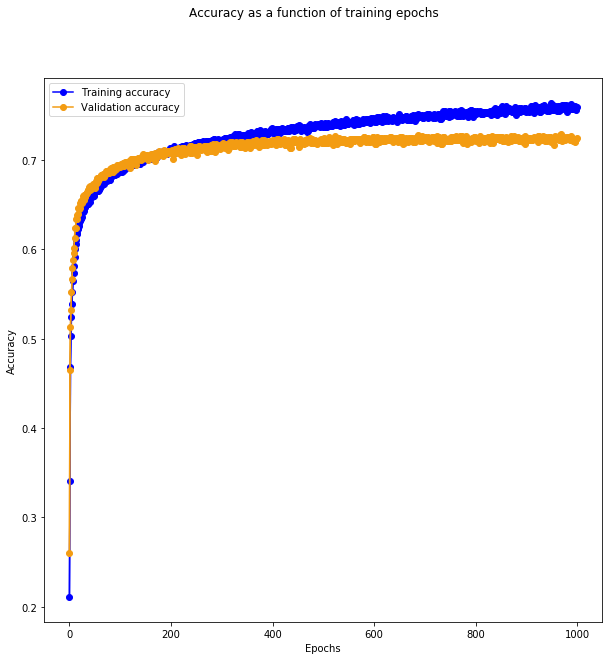

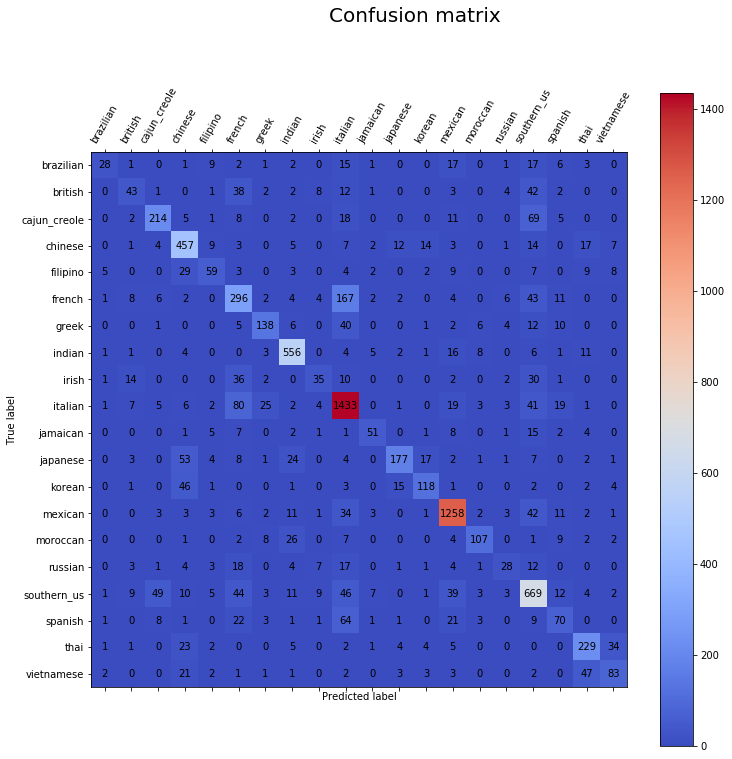

1. Accuracy = 0.724170956543 (i.e. 72.4170956543 %)

2. f1_scores for each class:

           brazilian:	0.3836
             british:	0.3399
        cajun_creole:	0.6826
             chinese:	0.7473
            filipino:	0.4797
              french:	0.5207
               greek:	0.6635
              indian:	0.8640
               irish:	0.3448
             italian:	0.8091
            jamaican:	0.5829
            japanese:	0.6769
              korean:	0.6592
             mexican:	0.8931
            moroccan:	0.7063
             russian:	0.3478
         southern_us:	0.6802
             spanish:	0.3836
                thai:	0.7112
          vietnamese:	0.5304


3. avg f1_score (without considering class imbalance): 0.600337351163

4. avg f1_score (weighted by considering class imbalance): 0.714644855967



KeyError: u'Grey Poupon Dijon Mustard'

In [282]:
nn_embedding = NN_embedding()
nn_embedding.train(X_embedding_train, Y_embedding_train, X_embedding_test, Y_embedding_test)
nn_embedding.validate(X_embedding_test, Y_embedding_test)
nn_embedding.write_prediction('whats-cooking/test.json', 'Submissions/nn_embedding_submission.csv')

### 6.3 Train a SVM (with embeddings as features)

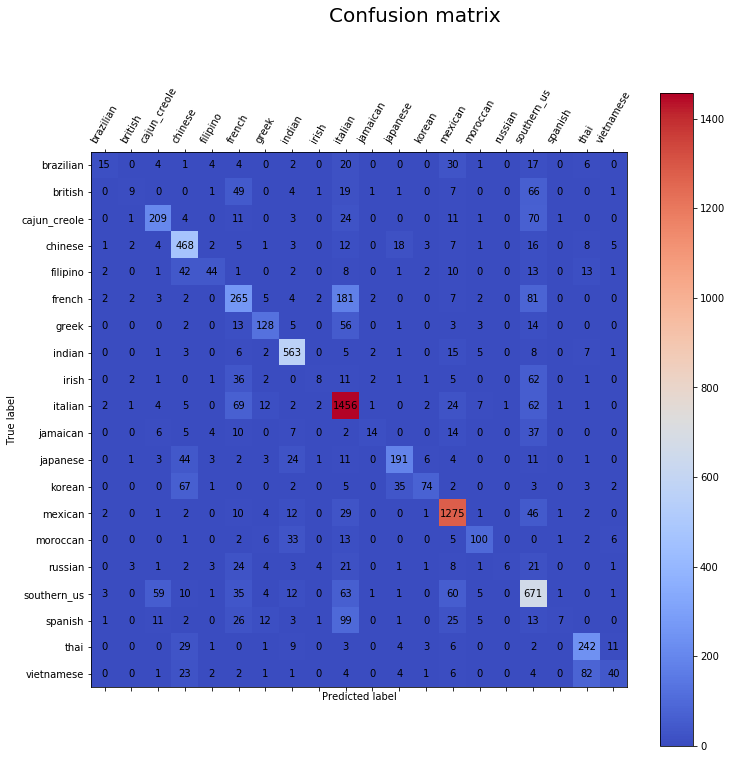

1. Accuracy = 0.692565545313 (i.e. 69.2565545313 %)

2. f1_scores for each class:

           brazilian:	0.2273
             british:	0.1000
        cajun_creole:	0.6491
             chinese:	0.7382
            filipino:	0.4251
              french:	0.4699
               greek:	0.6244
              indian:	0.8576
               irish:	0.1053
             italian:	0.7883
            jamaican:	0.2295
            japanese:	0.6761
              korean:	0.5139
             mexican:	0.8763
            moroccan:	0.6645
             russian:	0.1081
         southern_us:	0.6259
             spanish:	0.0642
                thai:	0.7128
          vietnamese:	0.3333


3. avg f1_score (without considering class imbalance): 0.489483917095

4. avg f1_score (weighted by considering class imbalance): 0.660308579351



In [280]:
from sklearn.svm import LinearSVC

# returns inverese of one-hot encoding
def inverse_one_hot(Y):
    y = np.zeros(shape=(Y.shape[0], ))
    for i in range(Y.shape[0]):
        y[i] = np.argmax(Y[i, :])
    return y

# train a linear SVM
svm = LinearSVC()
y_embedding_train = inverse_one_hot(Y_embedding_train)
svm.fit(X_embedding_train, y_embedding_train)

# evaluate results
y_embedding_predicted = svm.predict(X_embedding_test)
predictions = [ id_to_cuisine[y_embedding_predicted[i]] for i in range(y_embedding_predicted.shape[0])]
ground_truth_labels = [ id_to_cuisine[np.argmax(Y_embedding_test[i, :])] for i in range(Y_embedding_test.shape[0])]
common_validate(ground_truth_labels, predictions)

### 6.4 Train a GRU (with embeddings as features) with sorting

Note that GRU (Gated Recurrent Unit) is a type of recurrent neural network (RNN) that can take variable length sequences as input. Therefore, here we create feature vector of a recipe as follows:


Let $e_i$ be the embedding vector for ingredient i.
For a recipe $r$ consisting of ingredients $i_1, i_2, ..., i_n$ we create the feature vector $x_r$ by creating the sequence $\langle e_{i1}, e_{i2}, ..., e_{in}\rangle$. That is, $x_r = \langle e_{i1}, e_{i2}, ..., e_{in}\rangle$ and we feed $x_r$ as feature to GRU

We hope this should give better results than before since earlier we were simply averaging the embeddings

In [314]:
import json

# dimension of embeddings
embedding_dim = ingredient_to_embedding['pasta'].shape[0]

def create_embedding_supervised_for_RNN(infile, create_y=True, give_sorted=True):
    with open(infile, 'r') as file:
        data = json.load(file)
        X = []
        if create_y:
            Y = []
        for recipe in data:
            timesteps = len(recipe['ingredients'])
            if give_sorted:
                ordered_ingredients = sorted(recipe['ingredients'])
            else:
                ordered_ingredients = recipe['ingredients']
            
            x = np.zeros(shape=(timesteps, embedding_dim))
            if create_y:
                y = np.zeros(shape=(len(cuisines), ))
            
            for i, ingredient in enumerate(ordered_ingredients):
                if ingredient in ingredient_to_embedding:
                    x[i, :] = np.copy(ingredient_to_embedding[ingredient])
            if create_y:
                y[cuisine_to_id[recipe['cuisine']]] = 1.0
            
            X.append(x)
            if create_y:
                Y.append(y)
        
        if create_y:
            return X, Y
        else:
            return X

In [315]:
# create X, Y train matrices
X_rnn_train, Y_rnn_train = create_embedding_supervised_for_RNN('my_train_split.json')
print('len of X_rnn_train = {} with first element of shape = {}'.format(len(X_rnn_train), X_rnn_train[0].shape))
print('len of Y_rnn_train = {} with first element of shape = {}'.format(len(Y_rnn_train), Y_rnn_train[0].shape))

# create X, Y test matrices
X_rnn_test, Y_rnn_test = create_embedding_supervised_for_RNN('my_test_split.json')
print('len of X_rnn_test = {} with first element of shape = {}'.format(len(X_rnn_test), X_rnn_test[0].shape))
print('len of Y_rnn_test = {} with first element of shape = {}'.format(len(Y_rnn_test), Y_rnn_test[0].shape))

len of X_rnn_train = 27842 with first element of shape = (9, 128)
len of Y_rnn_train = 27842 with first element of shape = (20,)
len of X_rnn_test = 11932 with first element of shape = (17, 128)
len of Y_rnn_test = 11932 with first element of shape = (20,)


In [323]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU

class GRU_embedding:
    
    def __init__(self):
        self.is_trained = False
    
    # trains the model
    def train(self, X_train, Y_train, X_validation, Y_validation):
        
        # create GRU architecture
        self.model = Sequential()
        self.model.add(GRU(128, input_shape=(None, 128)))
        self.model.add(Dense(50, activation='relu'))
        self.model.add(Dropout(0.1))
        self.model.add(Dense(len(cuisines), activation='softmax'))
        
        # compile the model
        sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        self.model.compile(loss='categorical_crossentropy',
                      optimizer=sgd,
                      metrics=['accuracy'])

        # define your own history object
        train_accuracy = []
        test_accuracy = []

        # train the model, need to write custom training myself because of variable sized input
        num_epochs = 5
        N = len(X_train)
        self.is_trained = True
        for epoch in range(num_epochs):
            
            if epoch == 0:
                # calculate and show training, testing accuracies
                tr_ac = self.get_accuracy_on(X_train, Y_train)
                train_accuracy.append(tr_ac)
                te_ac = self.get_accuracy_on(X_validation, Y_validation)
                test_accuracy.append(te_ac)
                print('initially training accuracy = {}\ntesting accuracy = {}\n\n'.format(tr_ac, te_ac))
            
            for i in range(N):
                if (i + 1) % int((N / 4)) == 0:
                    print('\t epoch {} is completed {} %'.format(epoch, i * 100.0 / N))
                self.model.fit(np.array([ X_train[i] ]), np.array([ Y_train[i]] ), epochs=1, batch_size=1, verbose=0)
            print('epoch {}/{} done'.format(epoch + 1, num_epochs))
            
            # calculate and show training, testing accuracies
            tr_ac = self.get_accuracy_on(X_train, Y_train)
            train_accuracy.append(tr_ac)
            te_ac = self.get_accuracy_on(X_validation, Y_validation)
            test_accuracy.append(te_ac)
            print('training accuracy = {}\ntesting accuracy = {}\n\n'.format(tr_ac, te_ac))
                
        # plot train/validation accuracy as a function of epochs
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        fig.suptitle('Accuracy as a function of training epochs')
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Epochs')
        ax.plot(range(len(train_accuracy)), train_accuracy, color='blue')
        ax.plot(range(len(train_accuracy)), train_accuracy, marker='o', color='blue', label='Training accuracy')
        ax.plot(range(len(test_accuracy)), test_accuracy, color='#f39c12')
        ax.plot(range(len(test_accuracy)), test_accuracy, marker='o', color='#f39c12', label='Validation accuracy')

        ax.legend()
        plt.show()
        plt.close(fig)
    
    # returna accuracy of model on X, Y
    def get_accuracy_on(self, X, Y):
        predictions = self.predict(X)
        N = len(Y)
        ground_truth_labels = [ id_to_cuisine[np.argmax(Y[i])] for i in range(N)]
        from sklearn.metrics import accuracy_score
        accuracy = accuracy_score(ground_truth_labels, predictions)
        return accuracy
    
    # returns prediction results for samples of X_test
    def predict(self, X_test):
        assert self.is_trained, 'model not trained yet!'
        
        # predict
        Y_predicted = []
        N = len(X_test)
        for i in range(N):
            y = self.model.predict(np.array([ X_test[i] ]))
            Y_predicted.append(y[0])
        
        # convert one-hot predictions to cuisine labels
        predictions = []
        for i in range(N):
            predictions.append(id_to_cuisine[np.argmax(Y_predicted[i])])
                
        return predictions
    
    # validates already trained model against X_test, Y_test
    def validate(self, X_test, Y_test):
        assert self.is_trained, 'model not trained yet!'
        predictions = self.predict(X_test)
        N = len(Y_test)
        ground_truth_labels = [ id_to_cuisine[np.argmax(Y_test[i])] for i in range(N) ]
        common_validate(ground_truth_labels, predictions)
    
    # writes out prediction of already trained model on samples of X_test
    def write_prediction(self, infile, outfile):
        assert self.is_trained, 'model not trained yet!'
        
        X = create_embedding_supervised_for_RNN(infile, create_y=False)
        ids = []
        with open(infile, 'r') as file:
            data = json.load(file)
            for recipe in data:
                ids.append(recipe['id'])
        
        with open(outfile, 'w') as out_file:
            out_file.write('id,cuisine\n')
            predictions = self.predict(X)
            assert len(ids) == len(predictions), 'these should be equal'
            N = len(ids)
            for i in range(N):
                out_file.write('{},{}\n'.format(ids[i], predictions[i]))

initially training accuracy = 0.0653329502191
testing accuracy = 0.0660408984244


	 epoch 0 is completed 24.994612456 %
	 epoch 0 is completed 49.992816608 %
	 epoch 0 is completed 74.99102076 %
	 epoch 0 is completed 99.989224912 %
epoch 1/10 done
training accuracy = 0.62445226636
testing accuracy = 0.622527656721


	 epoch 1 is completed 24.994612456 %
	 epoch 1 is completed 49.992816608 %
	 epoch 1 is completed 74.99102076 %
	 epoch 1 is completed 99.989224912 %
epoch 2/10 done
training accuracy = 0.629121471159
testing accuracy = 0.624790479383


	 epoch 2 is completed 24.994612456 %
	 epoch 2 is completed 49.992816608 %
	 epoch 2 is completed 74.99102076 %
	 epoch 2 is completed 99.989224912 %
epoch 3/10 done
training accuracy = 0.65724445083
testing accuracy = 0.651357693597


	 epoch 3 is completed 24.994612456 %
	 epoch 3 is completed 49.992816608 %
	 epoch 3 is completed 74.99102076 %
	 epoch 3 is completed 99.989224912 %
epoch 4/10 done
training accuracy = 0.676639609223
tes

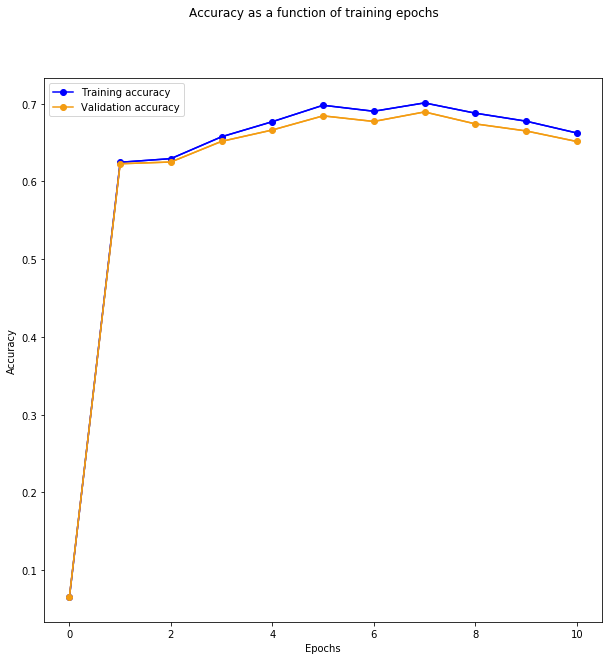

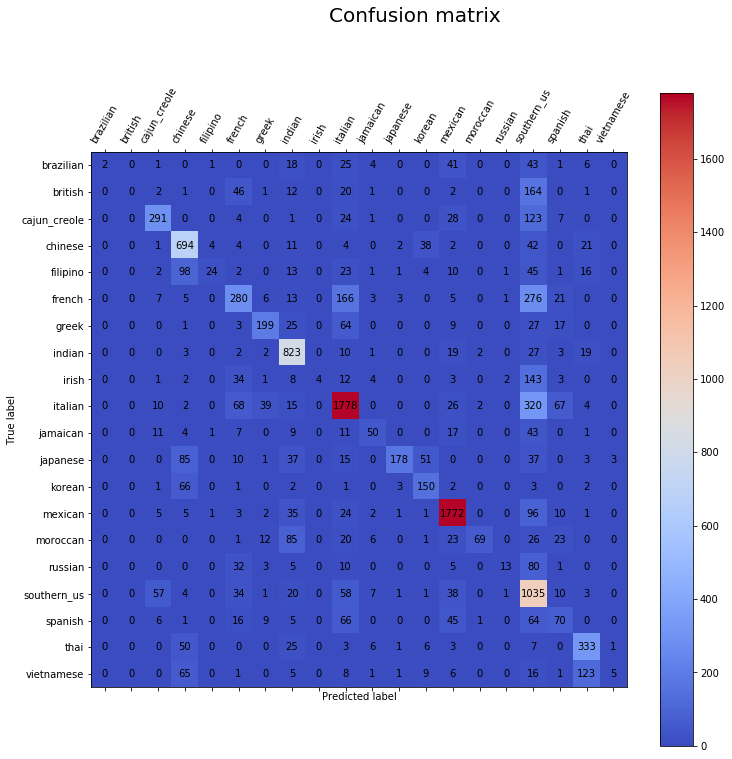

1. Accuracy = 0.651190077104 (i.e. 65.1190077104 %)

2. f1_scores for each class:

           brazilian:	0.0278
             british:	0.0000
        cajun_creole:	0.6659
             chinese:	0.7271
            filipino:	0.1765
              french:	0.4198
               greek:	0.6409
              indian:	0.7921
               irish:	0.0362
             italian:	0.7610
            jamaican:	0.4149
            japanese:	0.5827
              korean:	0.6098
             mexican:	0.8829
            moroccan:	0.4059
             russian:	0.1557
         southern_us:	0.5325
             spanish:	0.2703
                thai:	0.6880
          vietnamese:	0.0400


3. avg f1_score (without considering class imbalance): 0.441492887073

4. avg f1_score (weighted by considering class imbalance): 0.619283368184



In [322]:
gru_embedding = GRU_embedding()
gru_embedding.train(X_rnn_train, Y_rnn_train, X_rnn_test, Y_rnn_test)
gru_embedding.validate(X_rnn_test, Y_rnn_test)
gru_embedding.write_prediction('whats-cooking/test.json', 'Submissions/gru_embedding_sorted_submission.csv')

Kaggle accuracy: **64.189%**

Note: in above, one epoch takes around 7 minutes. 10 epochs took around 1 hr 10 mins

Note that above we had sorted the ingredients of a given recipe in lexicographic order as a preprocessing step

### 6.5 Train a GRU (with embeddings as features) without sorting

Trying it again without sorting ingredients of each recipe (i.e. in original order), this may be useful in case the ingredients are given to us in an ordered manner that is particular/characteristic to the recipe

len of X_rnn_train = 27842 with first element of shape = (9, 128)
len of Y_rnn_train = 27842 with first element of shape = (20,)
len of X_rnn_test = 11932 with first element of shape = (17, 128)
len of Y_rnn_test = 11932 with first element of shape = (20,)
initially training accuracy = 0.0564973780619
testing accuracy = 0.0565705665437


	 epoch 0 is completed 24.994612456 %
	 epoch 0 is completed 49.992816608 %
	 epoch 0 is completed 74.99102076 %
	 epoch 0 is completed 99.989224912 %
epoch 1/5 done
training accuracy = 0.604662021407
testing accuracy = 0.600234663091


	 epoch 1 is completed 24.994612456 %
	 epoch 1 is completed 49.992816608 %
	 epoch 1 is completed 74.99102076 %
	 epoch 1 is completed 99.989224912 %
epoch 2/5 done
training accuracy = 0.637418288916
testing accuracy = 0.631411330875


	 epoch 2 is completed 24.994612456 %
	 epoch 2 is completed 49.992816608 %
	 epoch 2 is completed 74.99102076 %
	 epoch 2 is completed 99.989224912 %
epoch 3/5 done
training accuracy = 

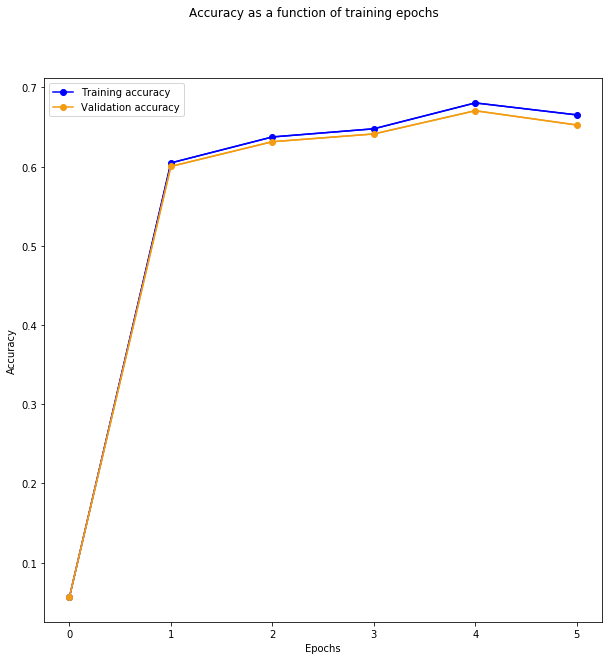

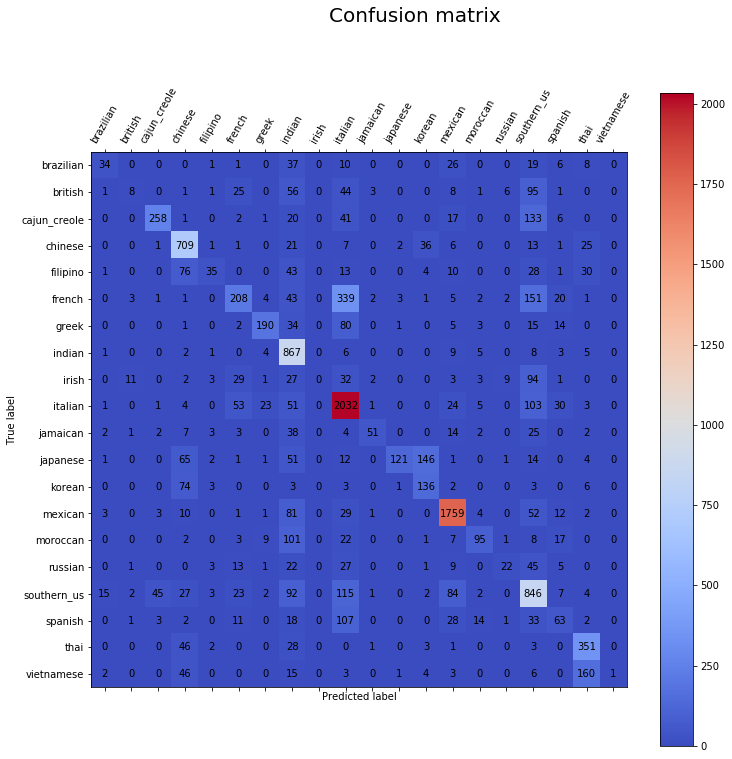

1. Accuracy = 0.652531009051 (i.e. 65.2531009051 %)

2. f1_scores for each class:

           brazilian:	0.3350
             british:	0.0578
        cajun_creole:	0.6507
             chinese:	0.7467
            filipino:	0.2341
              french:	0.3580
               greek:	0.6529
              indian:	0.6776
               irish:	0.0000
             italian:	0.7731
            jamaican:	0.4722
            japanese:	0.4408
              korean:	0.4814
             mexican:	0.8841
            moroccan:	0.4726
             russian:	0.2304
         southern_us:	0.5709
             spanish:	0.2681
                thai:	0.6763
          vietnamese:	0.0083


3. avg f1_score (without considering class imbalance): 0.44954677594

4. avg f1_score (weighted by considering class imbalance): 0.614139014297



In [324]:
# create X, Y train matrices
X_rnn_train, Y_rnn_train = create_embedding_supervised_for_RNN('my_train_split.json', give_sorted=False)
print('len of X_rnn_train = {} with first element of shape = {}'.format(len(X_rnn_train), X_rnn_train[0].shape))
print('len of Y_rnn_train = {} with first element of shape = {}'.format(len(Y_rnn_train), Y_rnn_train[0].shape))

# create X, Y test matrices
X_rnn_test, Y_rnn_test = create_embedding_supervised_for_RNN('my_test_split.json', give_sorted=False)
print('len of X_rnn_test = {} with first element of shape = {}'.format(len(X_rnn_test), X_rnn_test[0].shape))
print('len of Y_rnn_test = {} with first element of shape = {}'.format(len(Y_rnn_test), Y_rnn_test[0].shape))

gru_embedding = GRU_embedding()
gru_embedding.train(X_rnn_train, Y_rnn_train, X_rnn_test, Y_rnn_test)
gru_embedding.validate(X_rnn_test, Y_rnn_test)
gru_embedding.write_prediction('whats-cooking/test.json', 'Submissions/gru_sorted_embedding_submission.csv')

## 7. Clustering-based heuristic

We perform ​clustering​ of ingredients using ​K-means​ on Node2Vec embeddings of ingredient-ingredient network(we set K = # cuisines). We ​analyze​ if these generated clusters have one-to-one correlation with different cuisines. If yes, we can use these clusters to create a prediction heuristic in which the cuisine having most number of test ingredients (i.e. the cluster having most number of nodes out of a given set of nodes) is picked

In [330]:
from sklearn.cluster import KMeans

# keep only those ingredients that have embeddings
valid_ingredients = []
for ingredient in list(ingredients):
    if ingredient in ingredient_to_embedding:
        valid_ingredients.append(ingredient)

# create matrix of embeddings of each ingredient
X = np.zeros(shape=(len(valid_ingredients), embedding_dim))
list_ingredients = list(valid_ingredients)
for i, ingredient in enumerate(list_ingredients):
    X[i, :] = ingredient_to_embedding[ingredient]
print('X.shape = {}'.format(X.shape))

# do clustering with kmeans
kmeans = KMeans(n_clusters=len(cuisines)).fit(X)
ingredient_to_cluster_id = {}
for l, label in enumerate(kmeans.labels_):
    ingredient_to_cluster_id[list_ingredients[l]] = label

X.shape = (6070, 128)


In [331]:
print(ingredient_to_cluster_id['pasta'])
print(ingredient_to_cluster_id['pasta sauce'])

print(ingredient_to_cluster_id['rajma'])
print(ingredient_to_cluster_id['garam masala'])

12
12
17
17


We see above that pasta and pasta sauce are in same cluster (possibly italian cluster)
And we also see that rajma and garam masala are in same cluster (possibly indian cluster)

Now we print for each cluster, which cuisine has the highest frequency of occurrence with the ingredients in that cluster

In [342]:
# calculate for each ingredient the frequency with which each cuisine occurs  along with it
ingredient_cuisine_count_map = {}
# cuisine_count_map = {}
with open('my_train_split.json', 'r') as in_file:
    data = json.load(in_file)
    for recipe in data:
        for ingredient in recipe['ingredients']:
            
            if ingredient not in ingredient_cuisine_count_map:
                ingredient_cuisine_count_map[ingredient] = {}
            if recipe['cuisine'] not in ingredient_cuisine_count_map[ingredient]:
                ingredient_cuisine_count_map[ingredient][recipe['cuisine']] = 0
            ingredient_cuisine_count_map[ingredient][recipe['cuisine']] += 1
            
#             if recipe['cuisine'] not in cuisine_count_map:
#                     cuisine_count_map[recipe['cuisine']] = 0
#             cuisine_count_map[recipe['cuisine']] += 1

In [343]:
cluster_cuisine_count_map = {}
cuisine_count_map = {}
for ingredient in ingredient_cuisine_count_map:
    for cuisine in ingredient_cuisine_count_map[ingredient]:
        val = ingredient_cuisine_count_map[ingredient][cuisine]
        if ingredient_to_cluster_id[ingredient] not in cluster_cuisine_count_map:
            cluster_cuisine_count_map[ingredient_to_cluster_id[ingredient]] = {}
        if cuisine not in cluster_cuisine_count_map[ingredient_to_cluster_id[ingredient]]:
            cluster_cuisine_count_map[ingredient_to_cluster_id[ingredient]][cuisine] = 0
        cluster_cuisine_count_map[ingredient_to_cluster_id[ingredient]][cuisine] += val        
        
        if cuisine not in cuisine_count_map:
            cuisine_count_map[cuisine] = 0
        cuisine_count_map[cuisine] += val

In [344]:
# a function that returns cuisine in which a given cluster is used most
def most_used_cuisine_of_cluster(cluster_id):
    return max(cluster_cuisine_count_map[cluster_id].iteritems(), key=operator.itemgetter(1))[0]

# normalize the frequencies of counts
for cluster_id in cluster_cuisine_count_map:
    for cuisine in cluster_cuisine_count_map[cluster_id]:
        cluster_cuisine_count_map[cluster_id][cuisine] /= float(cuisine_count_map[cuisine])

num_clusters = len(cuisines)
set_cluster_labels = set()
for cluster_id in range(num_clusters):
    cuisine_label = most_used_cuisine_of_cluster(cluster_id)
    set_cluster_labels.add(cuisine_label)
    print('cluster #{} - {}'.format(cluster_id + 1, cuisine_label))
print('there were total of {} different cuisines as labels of clusters above'.format(len(set_cluster_labels)))

cluster #1 - irish
cluster #2 - french
cluster #3 - british
cluster #4 - korean
cluster #5 - mexican
cluster #6 - indian
cluster #7 - southern_us
cluster #8 - mexican
cluster #9 - spanish
cluster #10 - greek
cluster #11 - mexican
cluster #12 - filipino
cluster #13 - italian
cluster #14 - british
cluster #15 - thai
cluster #16 - cajun_creole
cluster #17 - brazilian
cluster #18 - indian
cluster #19 - japanese
cluster #20 - chinese
there were total of 16 different cuisines as labels of clusters above


** The above results seem interesting since they indicate that there are demarcated clusters corresponding to as many as 16 cuisines out of a total 20 cuisines**

Now we create and evaluate a prediction heuristic with the following logic:

- Say we are given a recipe $r$ with ingredients $i_1, i_2, ..., i_n$. Let $c_i$ denote the cuisine label of the cluster to which ingredient $i$ belongs. Then we pick the most frequently occurring cuisine in the list $c_{i1}, c_{i2}, ..., c_{in}$ as the prediction for recipe $r$

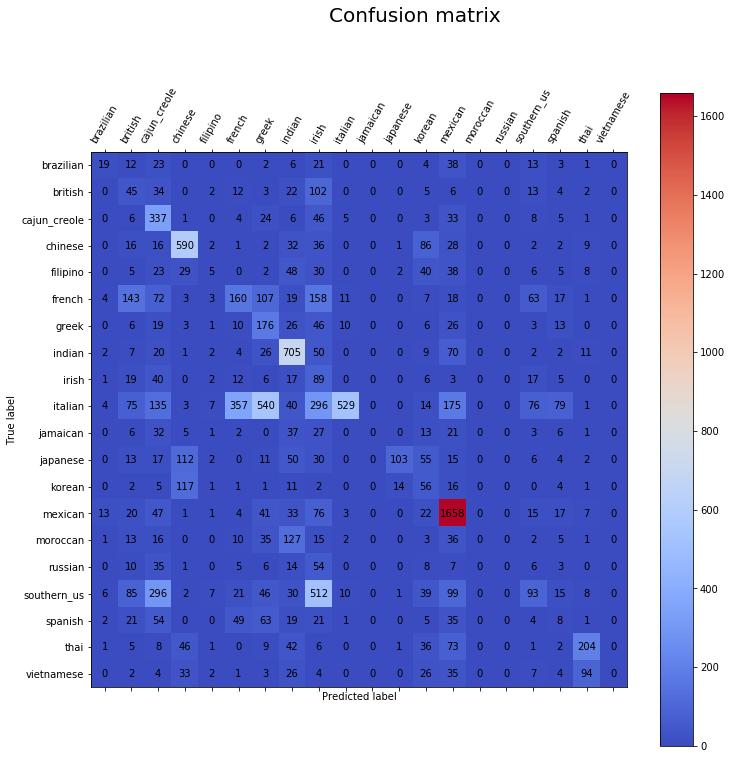

1. Accuracy = 0.400351994636 (i.e. 40.0351994636 %)

2. f1_scores for each class:

           brazilian:	0.1949
             british:	0.1183
        cajun_creole:	0.3937
             chinese:	0.6667
            filipino:	0.0357
              french:	0.2224
               greek:	0.2431
              indian:	0.6348
               irish:	0.0968
             italian:	0.3646
            jamaican:	0.0000
            japanese:	0.3801
              korean:	0.1662
             mexican:	0.7557
            moroccan:	0.0000
             russian:	0.0000
         southern_us:	0.1155
             spanish:	0.0329
                thai:	0.5178
          vietnamese:	0.0000


3. avg f1_score (without considering class imbalance): 0.246955479466

4. avg f1_score (weighted by considering class imbalance): 0.382993085787



In [351]:
with open('my_test_split.json', 'r') as in_file:
    data = json.load(in_file)
    ground_truth_labels = []
    predictions = []
    for recipe in data:
        
        candidates = []
        for ingredient in recipe['ingredients']:
            if ingredient in ingredient_to_cluster_id:
                cluster_id = ingredient_to_cluster_id[ingredient]
                candidates.append(most_used_cuisine_of_cluster(cluster_id))        
        # returns most common element in a list
        def most_common(lst):
            return max(set(lst), key=lst.count)
        prediction = most_common(candidates)
        
        predictions.append(prediction)
        ground_truth_labels.append(recipe['cuisine'])
    common_validate(ground_truth_labels, predictions)

## 8. Summary

| Model                | Accuracy | Weighted F1-score | Unweighted F1-score |
|----------------------|----------|-------------------|---------------------|
| Baseline #1          | 53.2     | 0.459             | 0.268               |
| Baseline #2          | 40.92    | 0.319             | 0.140               |
| Baseline #2(b)       | 52.97    | 0.450             | 0.249               |
| NN (1-hot)           | 77.82    | 0.776             | 0.701               |
| SVM (1-hot)          | 76.71    | 0.763             | 0.684               |
| NN (embedding)       | 72.41    | 0.714             | 0.600               |
| SVM (embedding)      | 69.25    | 0.660             | 0.489               |
| GRU (embedding)      | 65.11    | 0.619             | 0.441               |
| Clustering heuristic | 40.03    | 0.382             | 0.246               |

The above table shows the results that we have achieved with different models